<center><font size="4"><span style="color:blue">Detecção de Anomalias em poços de petróleo</span></font></center>

# 2. Imports and Configurations

In [1]:
pip install tsfresh

Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
import sys
sys.path.append(r'C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\stac')
import nonparametric_tests as stac
from math import ceil
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support

In [30]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [20]:
data_path = Path(r'C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset')
gamma = 1e-2
nu = 1e-3
random_state = 1
n_jobs = None
clfs = {'One Class SVM - RBF':     OneClassSVM(kernel='rbf', gamma=gamma, nu=nu),
        'One Class SVM - SIGMOID': OneClassSVM(kernel='sigmoid', gamma=gamma, nu=nu),
        'One Class SVM - POLY':    OneClassSVM(kernel='poly', gamma=gamma, nu=nu),
        'One Class SVM - LINEAR':  OneClassSVM(kernel='linear', gamma=gamma, nu=nu),
        'Isolation Forest': IsolationForest(n_estimators=200, 
                                            max_samples=0.75, 
                                            contamination=0.10, 
                                            bootstrap=False, 
                                            max_features=1.0),
        'Dummy':                   DummyClassifier(strategy='constant', constant=1)
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # In observations = seconds
min_normal_period_size = 20*60  # In observations = seconds
split_range = 0.6               # Train size/test size
max_samples_per_period = 15     # Limitation for safety
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
df_fc_p.pop('root_mean_square') # Excludes inappropriate feature
df_fc_p.pop('absolute_maximum') # Excludes inappropriate feature
max_nan_percent = 0.1           # For selection of useful variables
std_vars_min = 0.01             # For selection of useful variables
disable_progressbar = True      # For less output

In [21]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [22]:
def load_instance(instance_path):
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), 'invalid columns in the file {}: {}'\
            .format(str(instance_path), str(df.columns.tolist()))
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [23]:
def extract_samples(df, class_code):
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Discards the observations labels and replaces all nan with 0 
    # (tsfresh's requirement)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Initializes objects that will be return
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Find out max numbers of samples from normal, transient and in regime periods
    #
    # Gets indexes (first and last) without overlap with other periods
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Defines the initial numbers of samples for normal period
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Defines the max number of samples for transient period    
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Defines the max number of samples for in regime period
    if class_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # or end of this period
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Find out proper numbers of samples from normal, transient and in regime periods
    #
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    #print('num_train_samples: {}'.format(num_train_samples))
    #print('num_test_samples: {}'.format(num_test_samples))        
    #print('num_transient_samples: {}'.format(num_transient_samples))        
    #print('num_in_regime_samples: {}'.format(num_in_regime_samples))
    
    # Extracts samples from the normal period for training and for testing
    #
    # Gets indexes (first and last) without overlap with other periods
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Defines the proper step and extracts samples
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extracts samples for training
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extracts samples for testing
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extracts samples from the transient period (if it exists) for testing
    #  
    if (num_transient_samples) > 0:    
        # Defines the proper step and extracts samples
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Gets indexes (first and last) with possible overlap at the beginning of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extracts samples
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extracts samples from the in regime period (if it exists) for testing 
    #
    if (num_in_regime_samples) > 0:     
        # Defines the proper step and extracts samples
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Gets indexes (first and last) with possible overlap at the beginning or end of this period
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extracts samples
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test              

In [24]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs):
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)    
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            if clf_name!='Dummy': 
                clf.fit(X_train)
            else:
                clf.fit(X_train, np.array([1]*len(y_train))) # y_train must have at least one normal sample
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
            
            # Plots actual and predicted labels
            fig = plt.figure(figsize=(12,1))
            ax = fig.add_subplot(111)
            plt.plot(-(y_pred), marker=11, color='orange', linestyle='') # Inverted order (more natural)
            plt.plot(-(y_test), marker=10, color='green', linestyle='')  # Inverted order (more natural)
            ax.grid(False)
            ax.set_yticks([-1, 1])
            ax.set_yticklabels(['Normal', 'Abnormal'])
            ax.set_title(clf_name)            
            ax.set_xlabel('Sample')
            ax.legend(['Predicted labels', 'Actual labels'])
            plt.show()

            # Calculates the considered scores
            ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
            p, r, f1, _ = ret
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': p,
                                    'RECALL': r,
                                    'F1': f1,
                                    'TRAINING[s]': t_train, 
                                    'TESTING[s]': t_test}, ignore_index=True)

        except:
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': np.nan,
                                    'RECALL': np.nan,
                                    'F1': np.nan,
                                    'TRAINING[s]': np.nan, 
                                    'TESTING[s]': np.nan}, ignore_index=True)
        
    return scores

In [25]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

instance 1: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\1\WELL-00001_20140124093303.csv


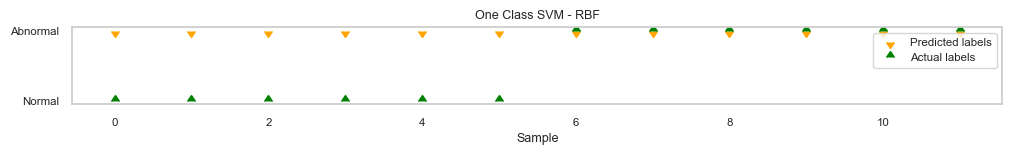

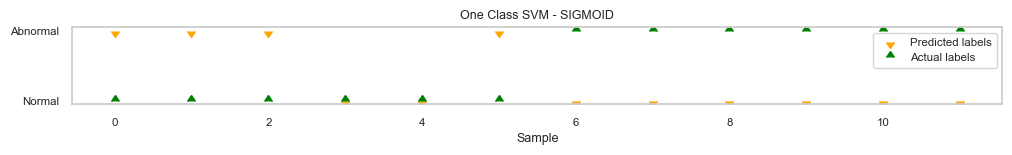

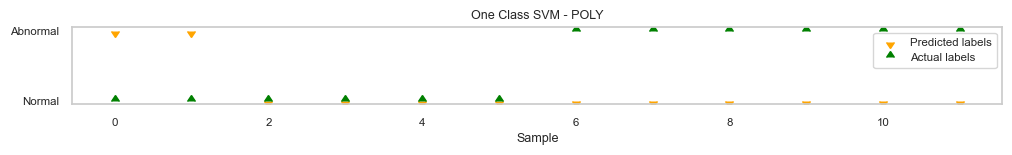

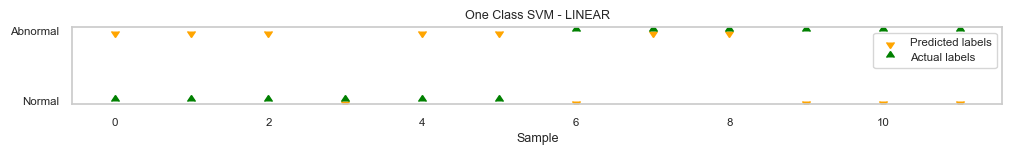

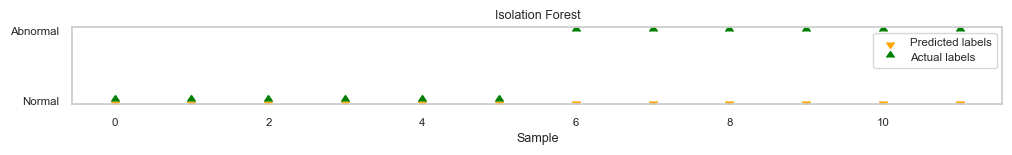

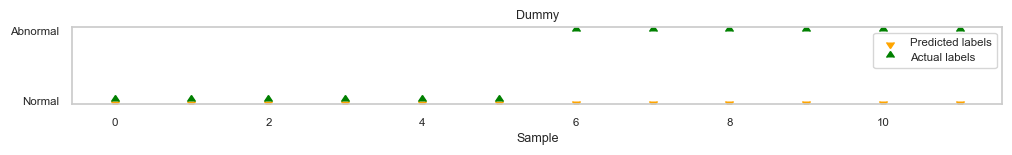

instance 2: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\1\WELL-00002_20140126161944.csv


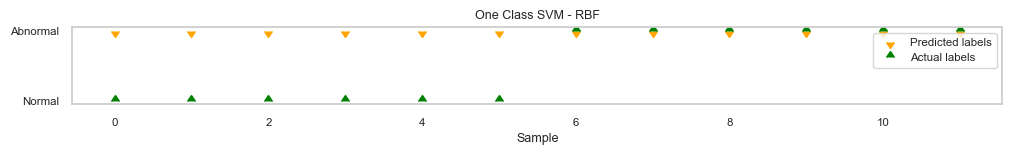

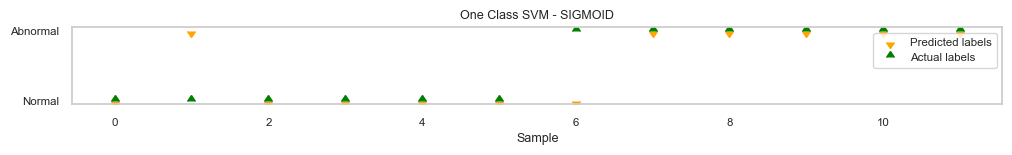

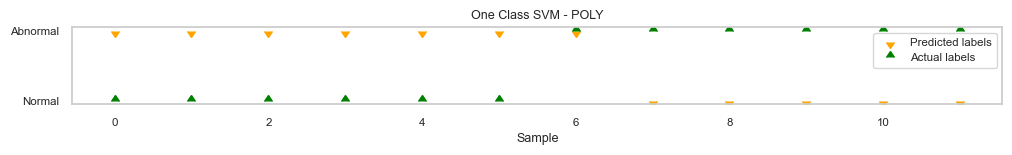

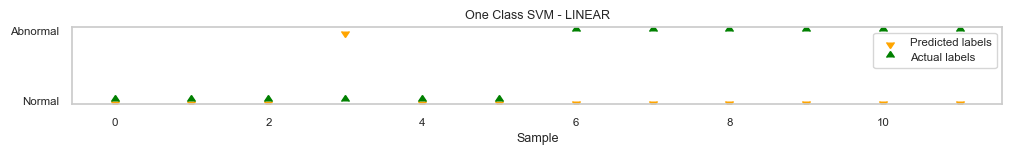

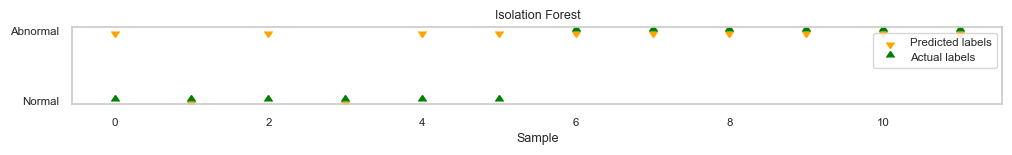

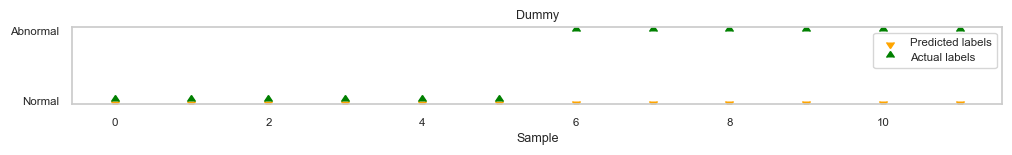

instance 3: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\1\WELL-00006_20170731180930.csv


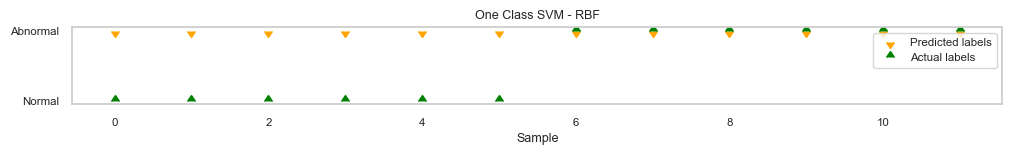

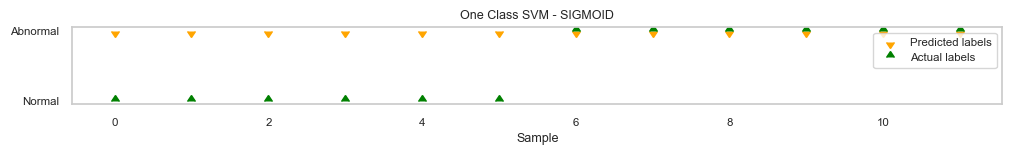

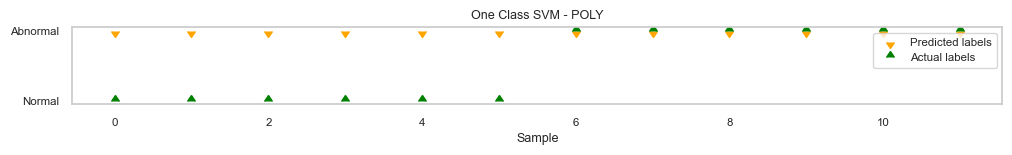

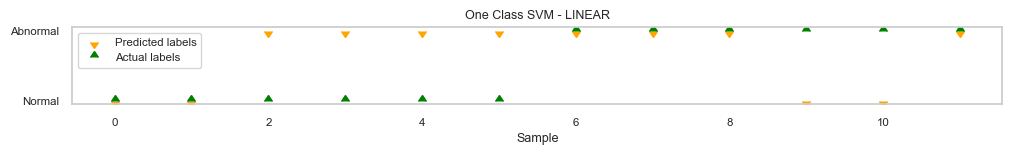

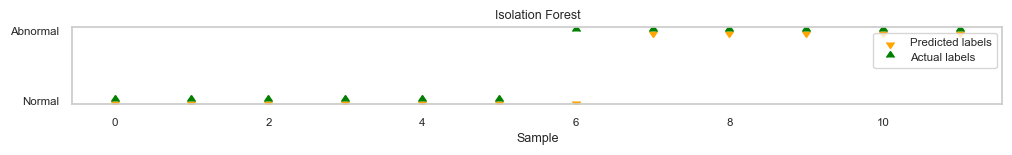

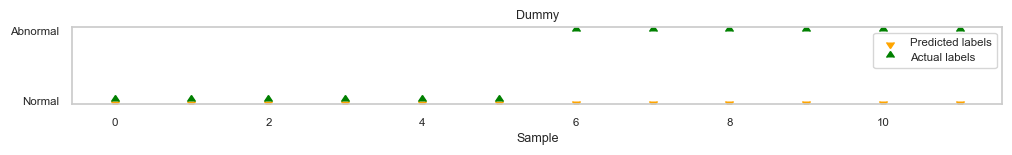

instance 4: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\1\WELL-00006_20170731220432.csv


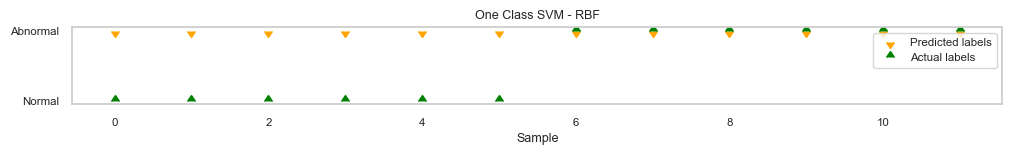

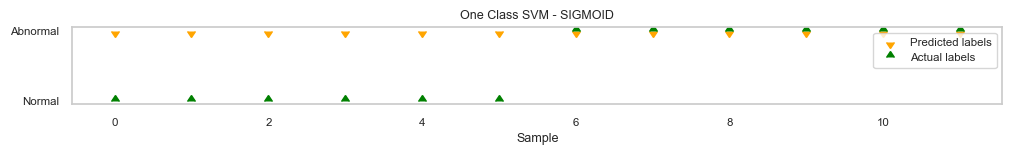

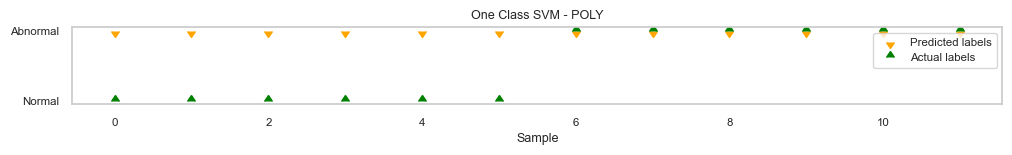

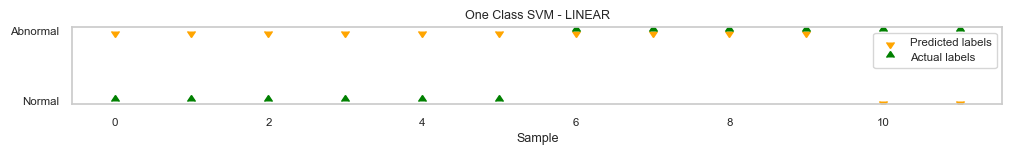

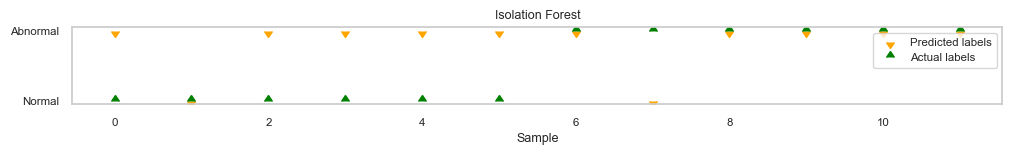

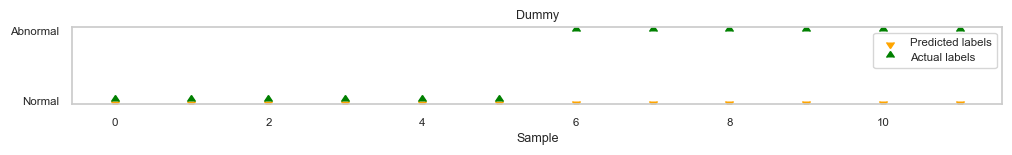

instance 5: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\1\WELL-00006_20180617200257.csv


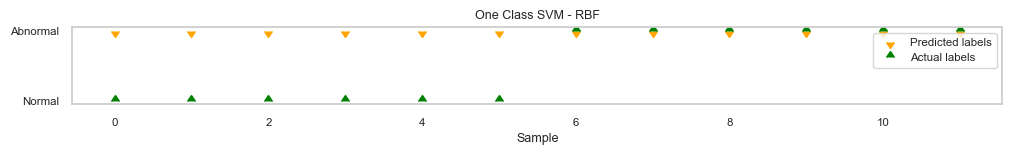

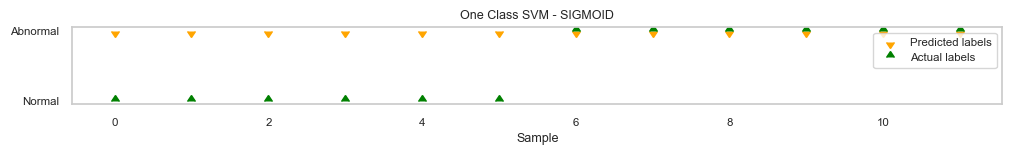

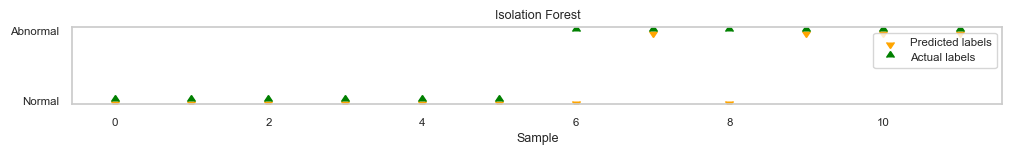

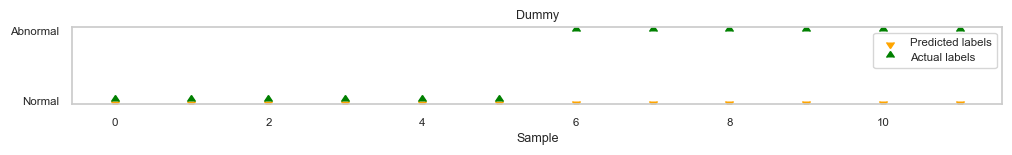

instance 6: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00002_20131104014101.csv


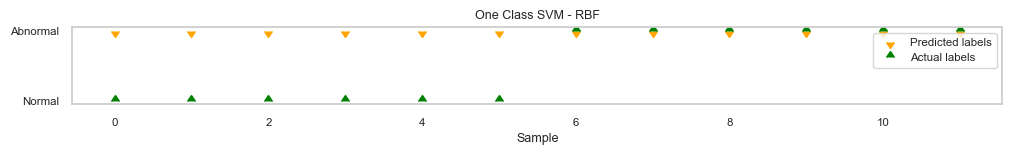

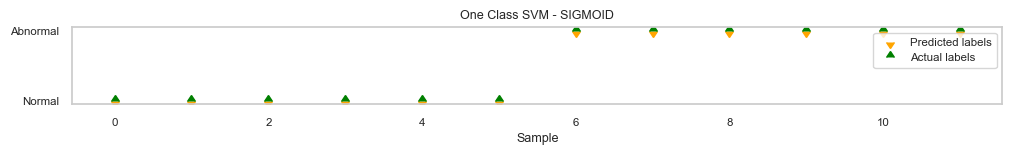

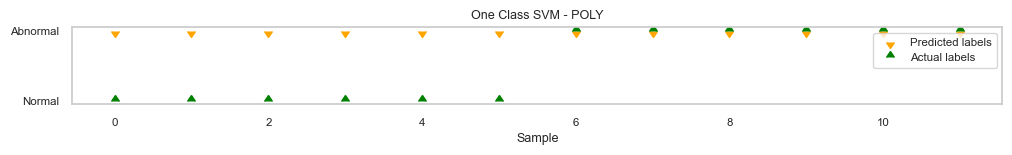

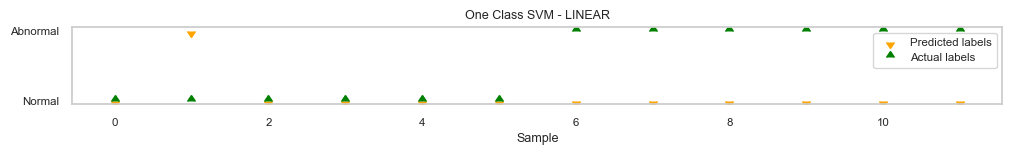

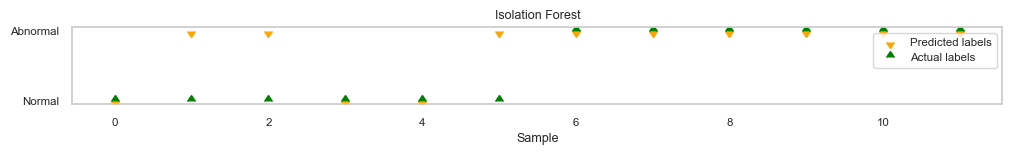

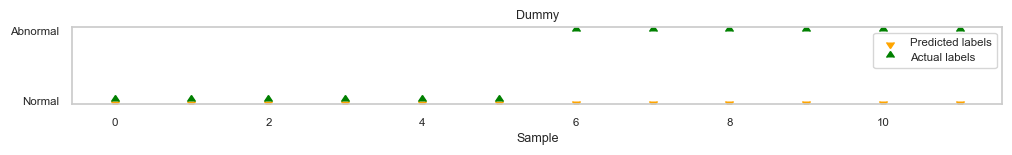

instance 7: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00003_20141122200000.csv
	skipped because normal_period_size is insufficient for training (0)
instance 8: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00003_20170728140240.csv
	skipped because normal_period_size is insufficient for training (0)
instance 9: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00003_20180206181001.csv
	skipped because normal_period_size is insufficient for training (0)
instance 10: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00009_20170313160804.csv


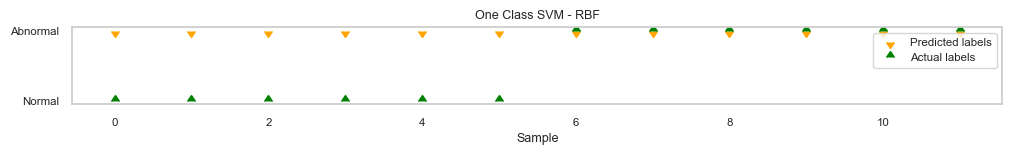

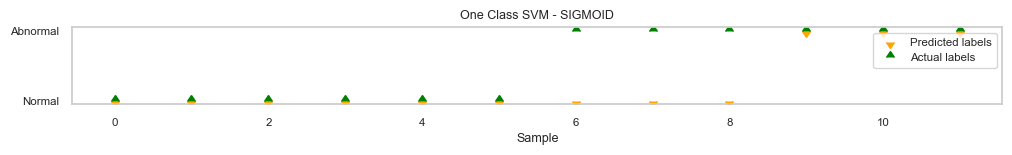

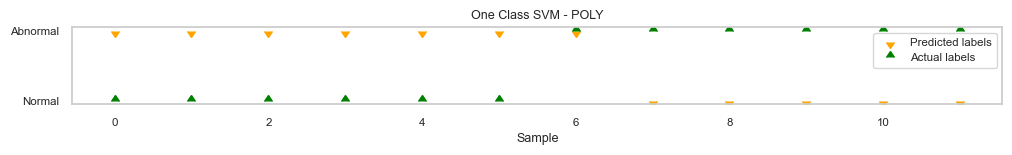

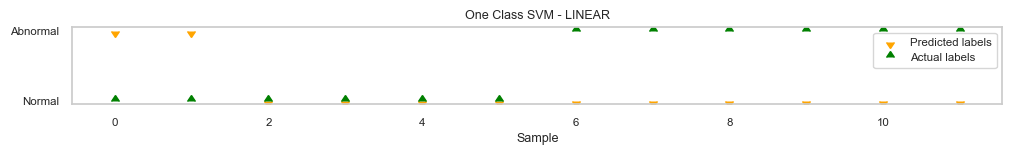

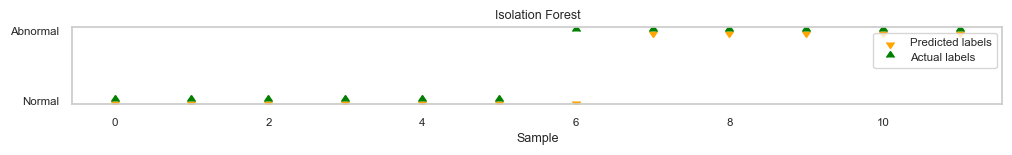

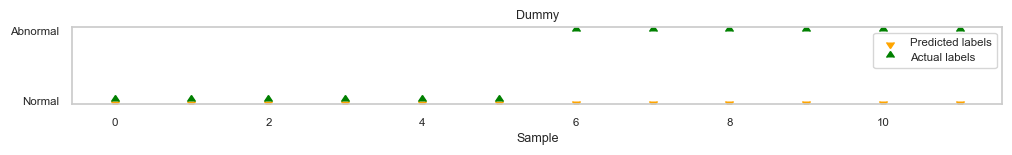

instance 11: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00010_20171218190131.csv


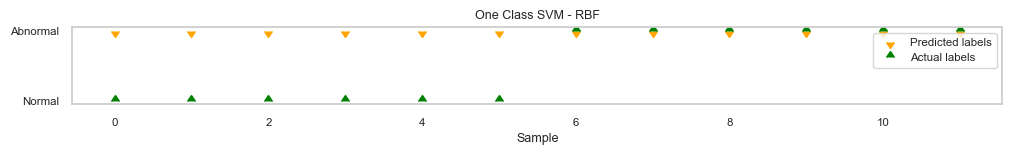

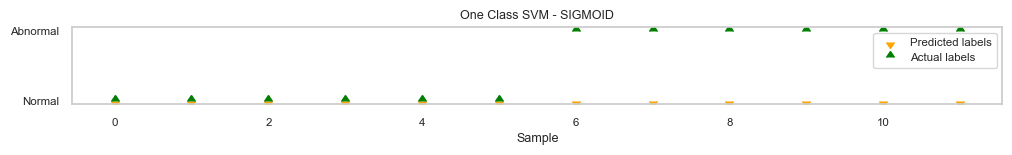

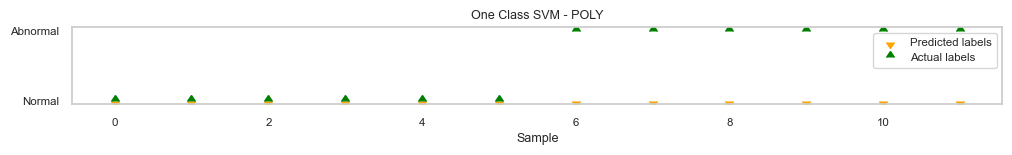

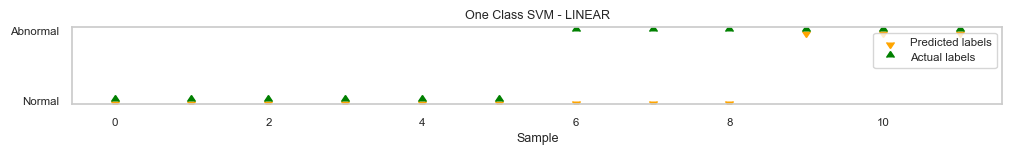

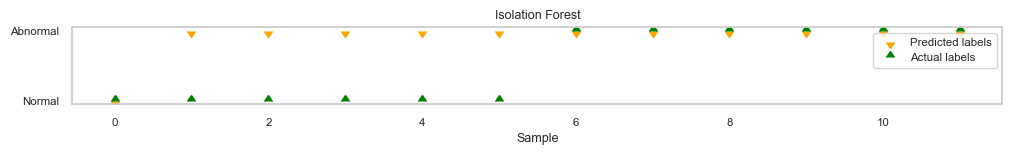

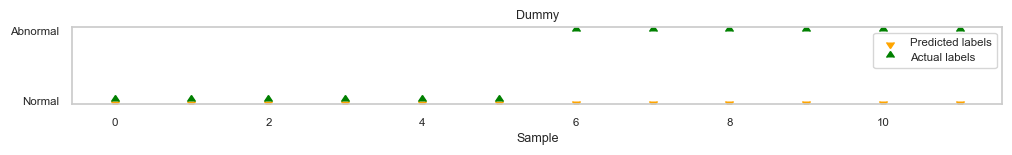

instance 12: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140530093203.csv


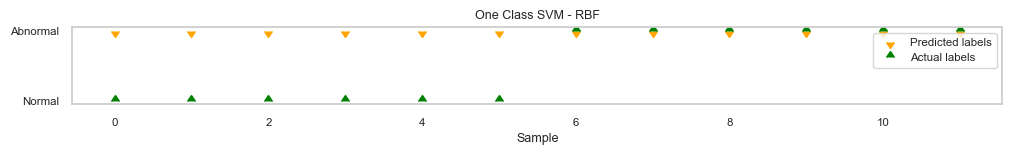

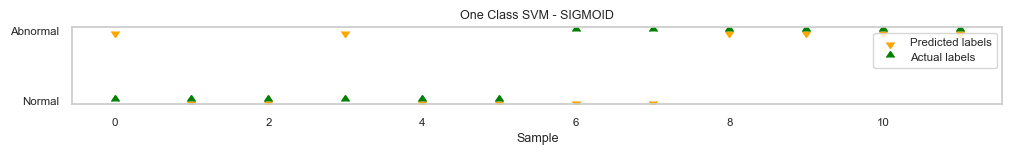

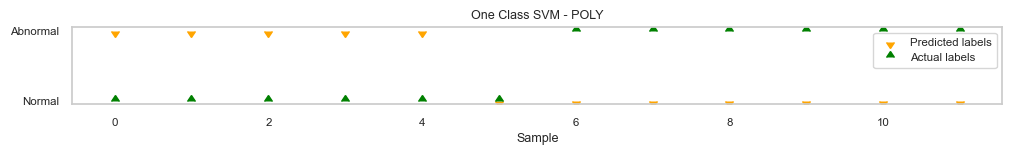

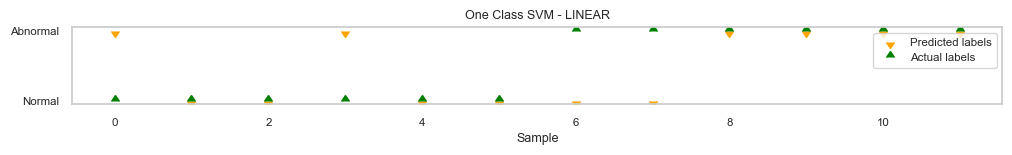

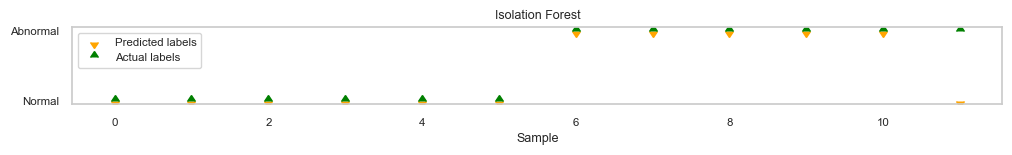

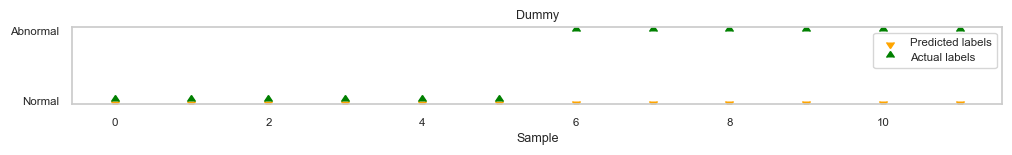

instance 13: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140606223810.csv


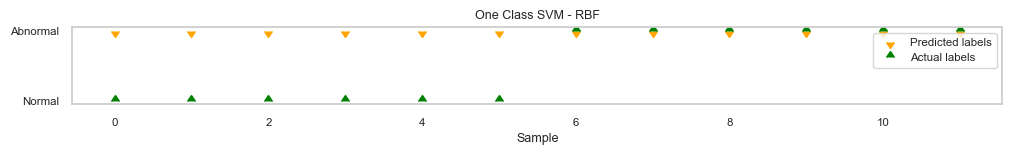

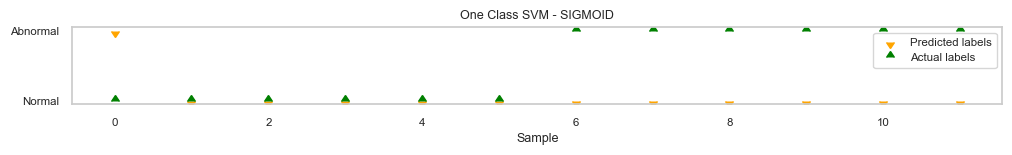

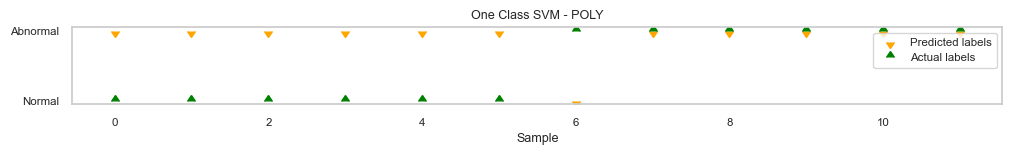

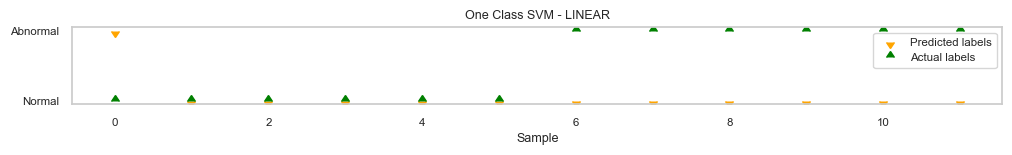

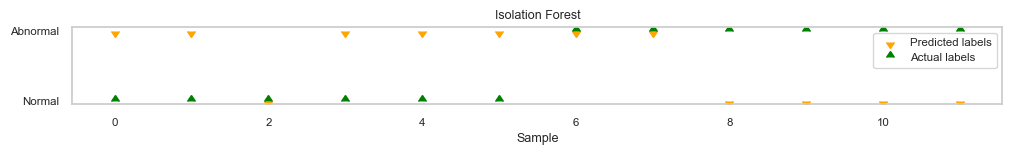

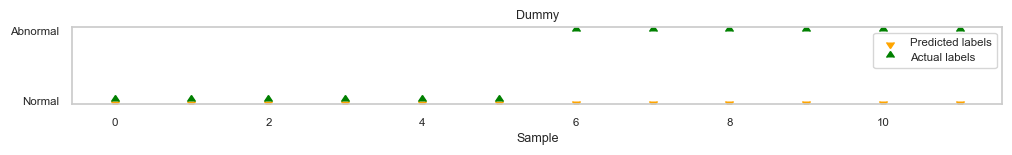

instance 14: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140726174523.csv
	skipped because normal_period_size is insufficient for training (1084)
instance 15: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140824000118.csv


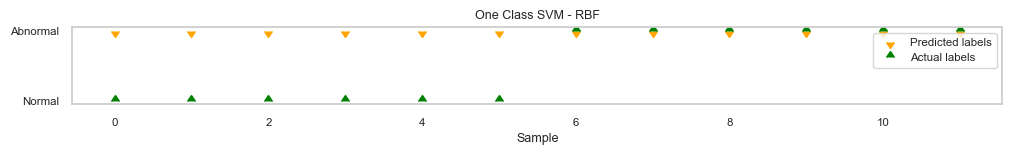

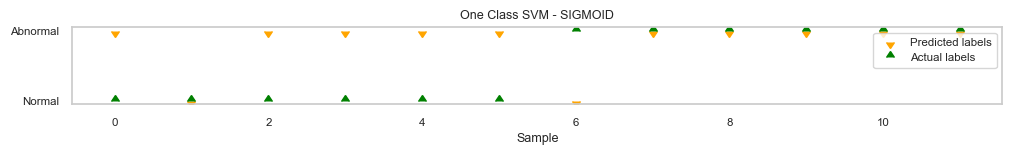

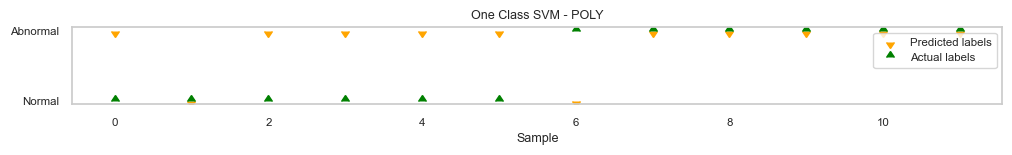

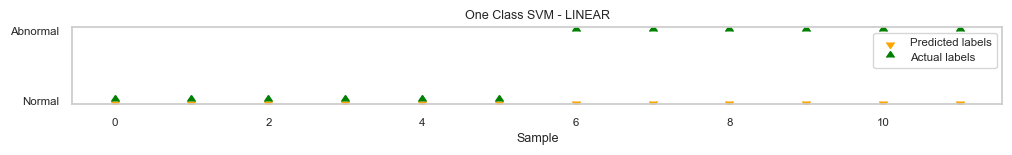

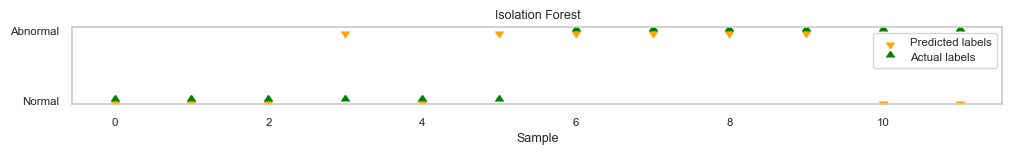

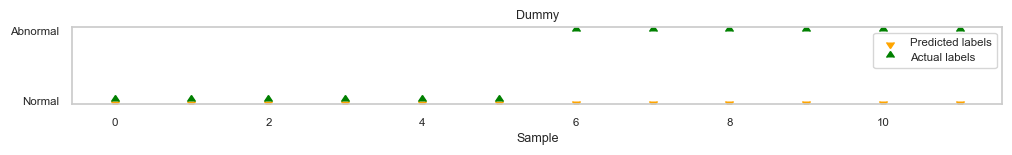

instance 16: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140916060300.csv


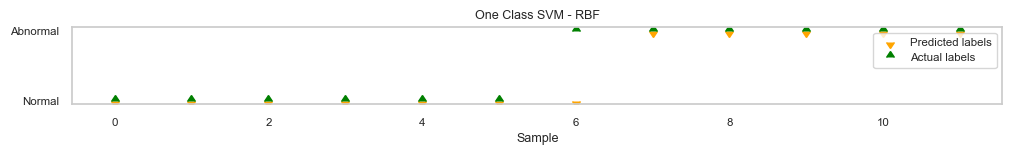

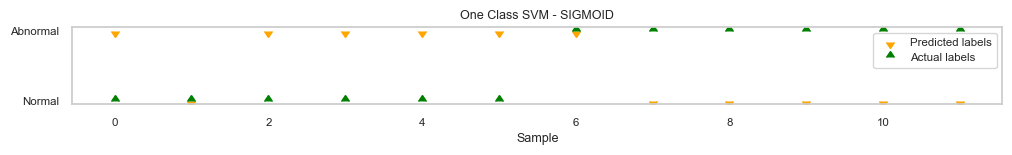

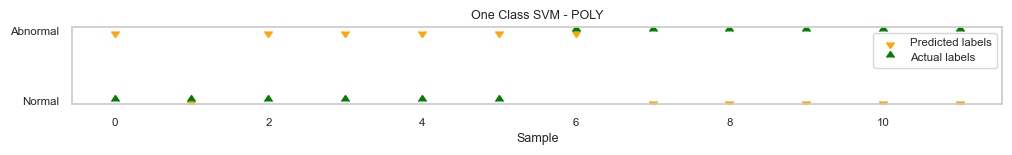

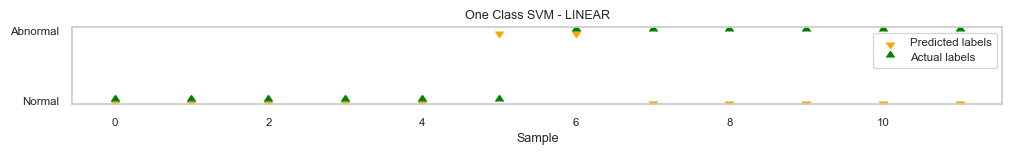

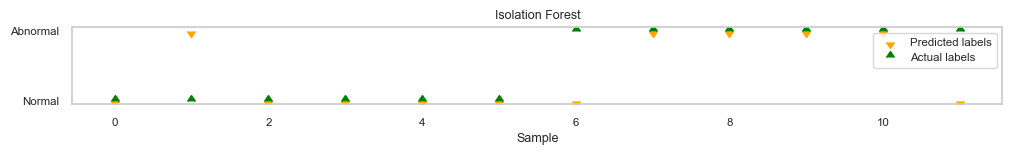

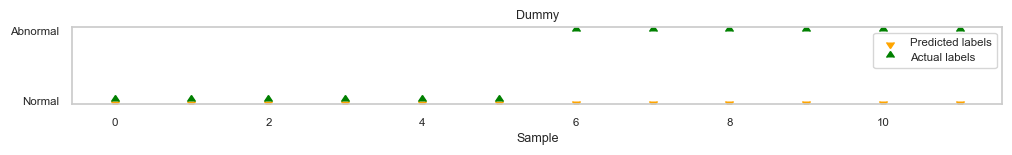

instance 17: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140921193228.csv


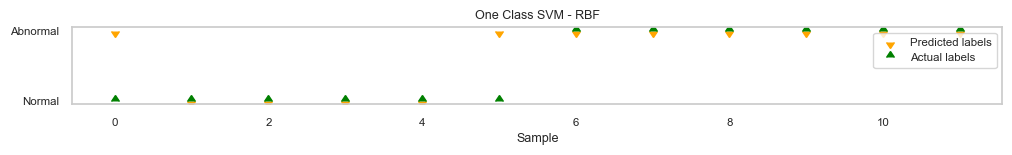

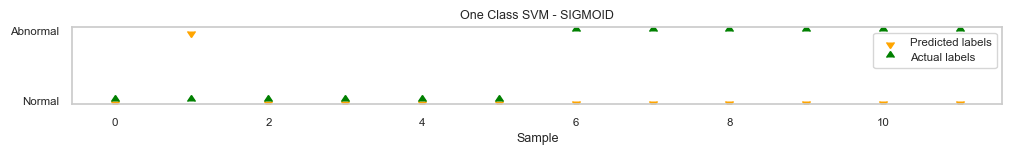

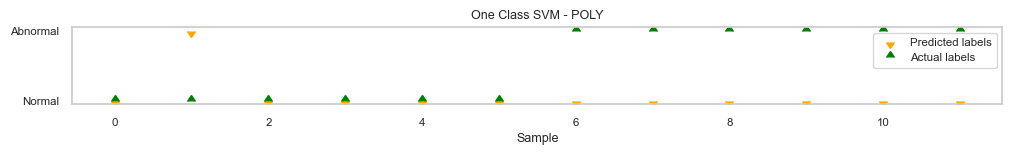

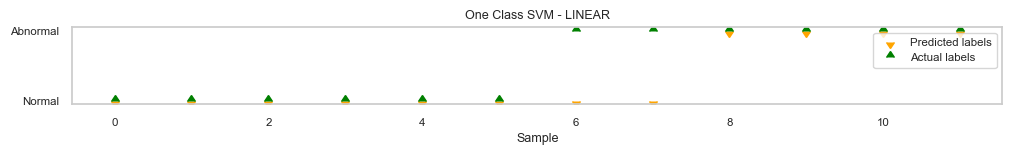

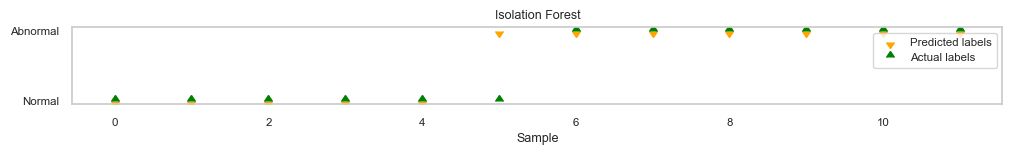

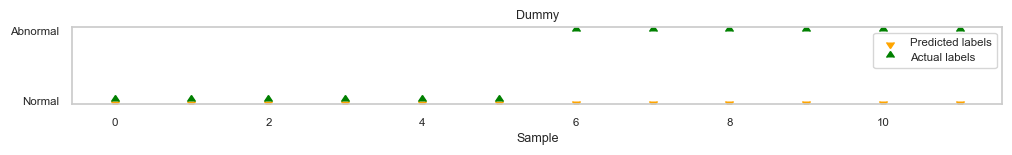

instance 18: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140928100056.csv


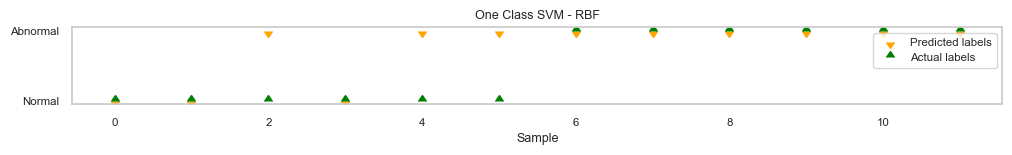

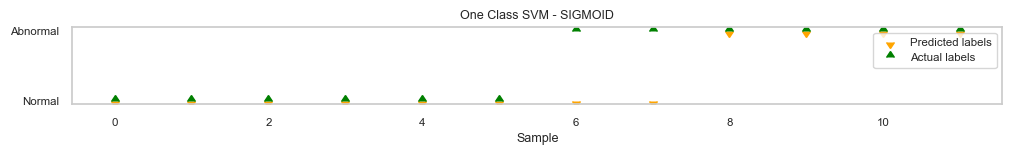

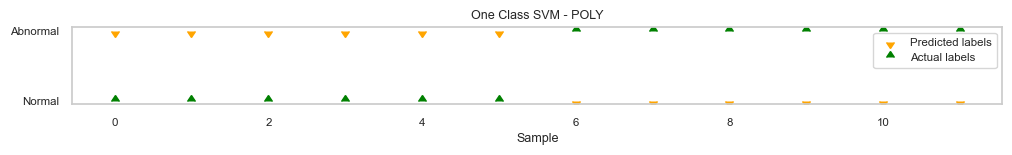

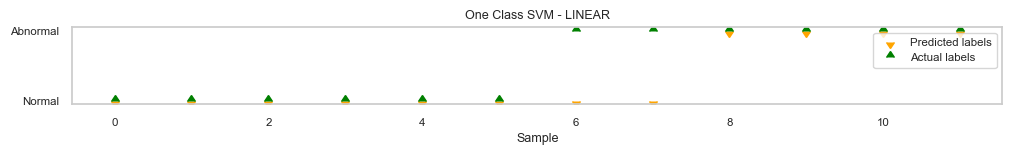

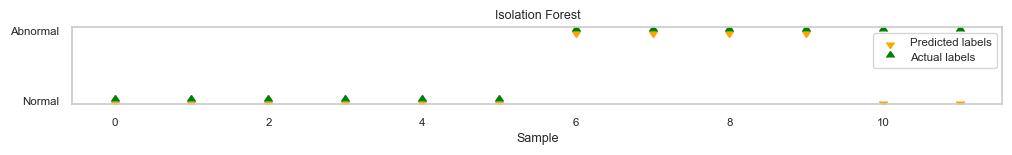

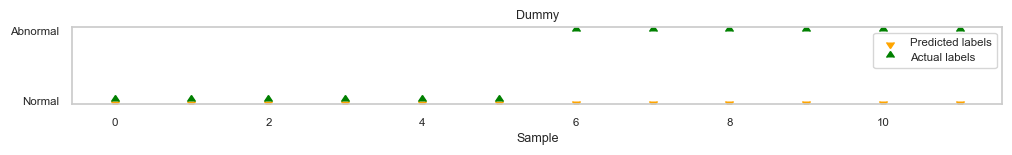

instance 19: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140929163332.csv


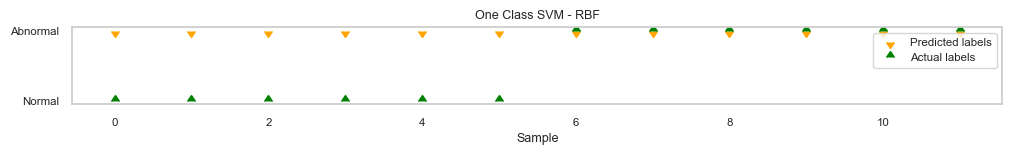

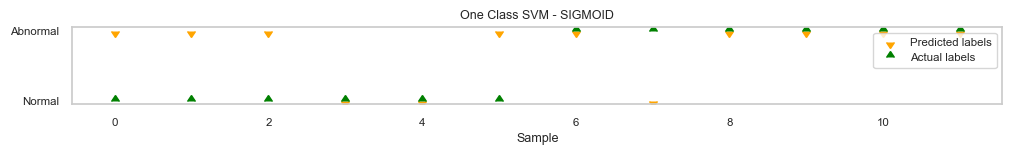

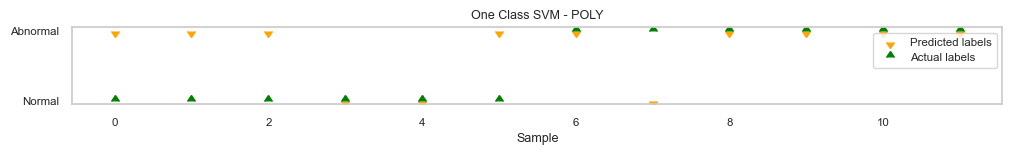

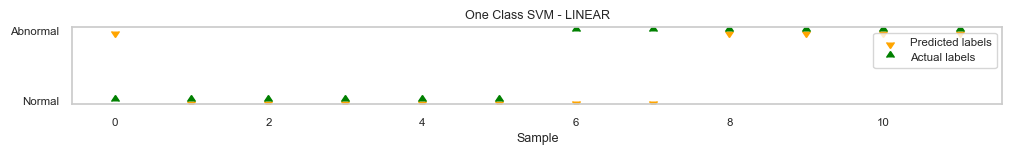

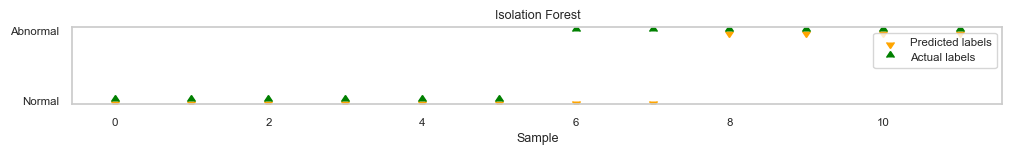

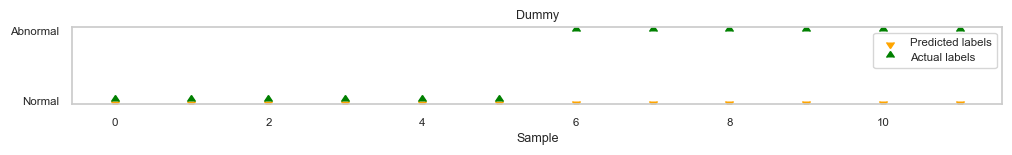

instance 20: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20140929220121.csv


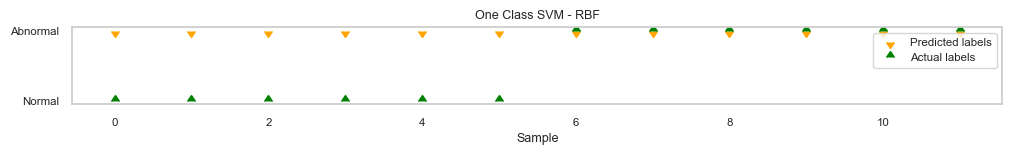

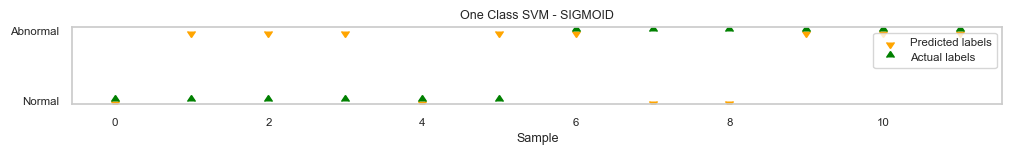

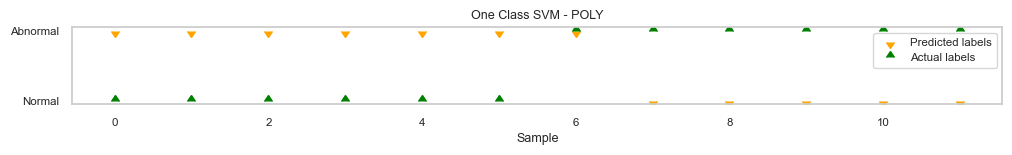

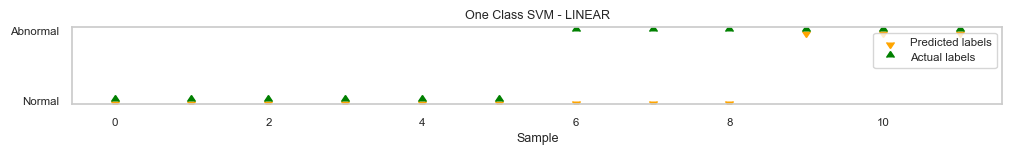

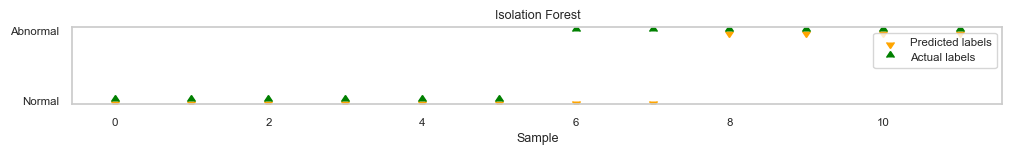

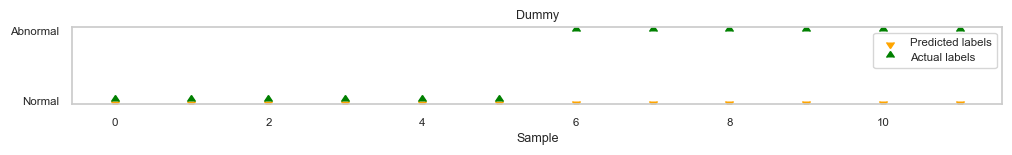

instance 21: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20141005170056.csv


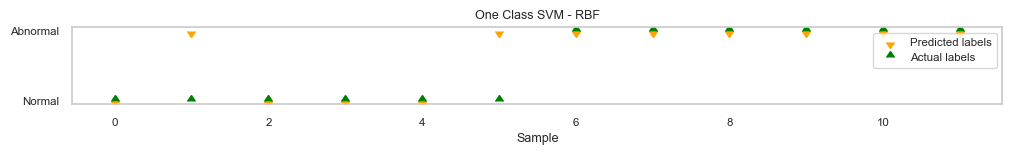

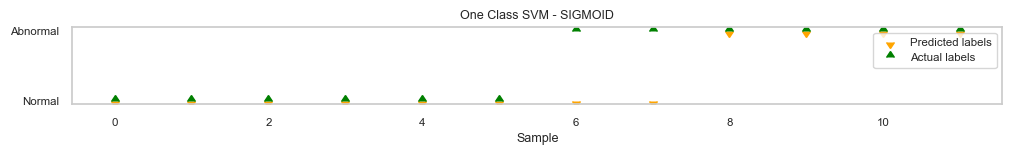

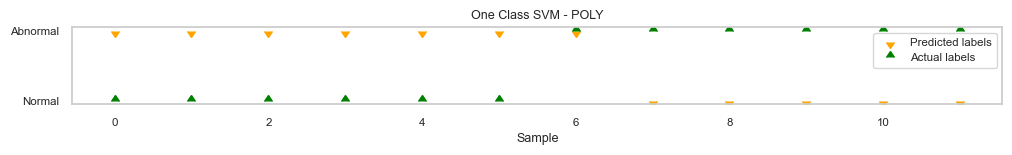

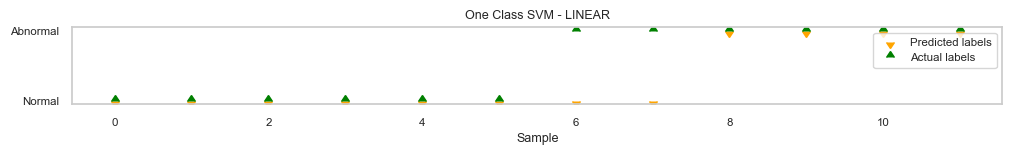

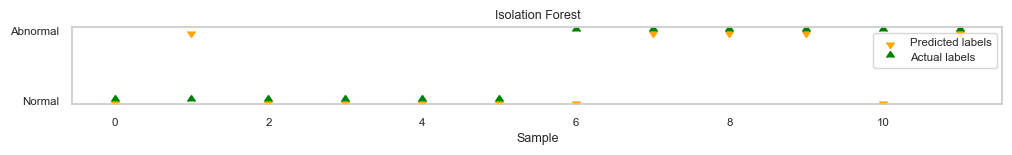

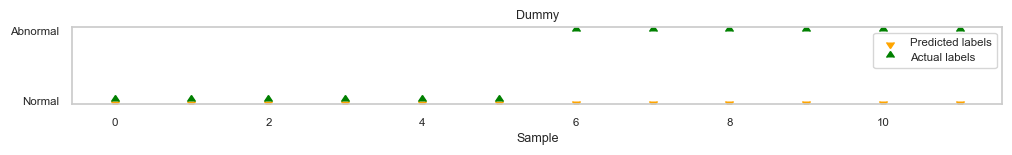

instance 22: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00011_20141006160121.csv


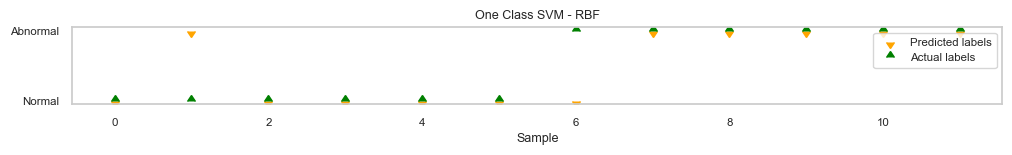

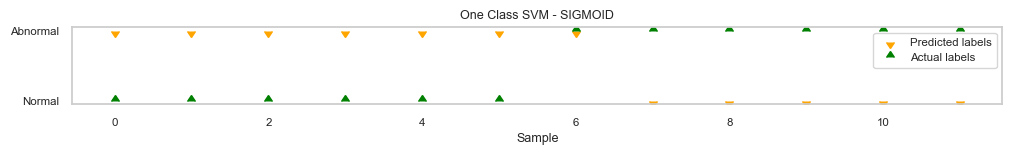

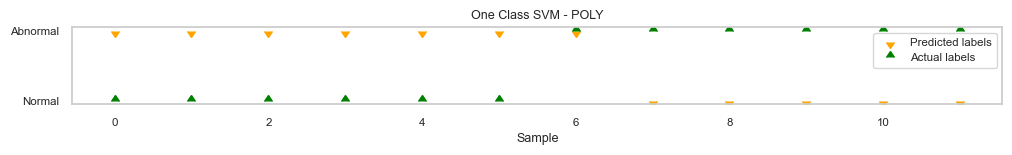

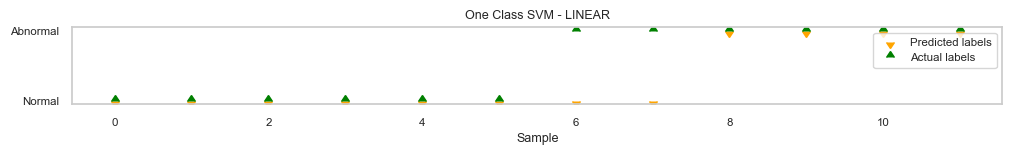

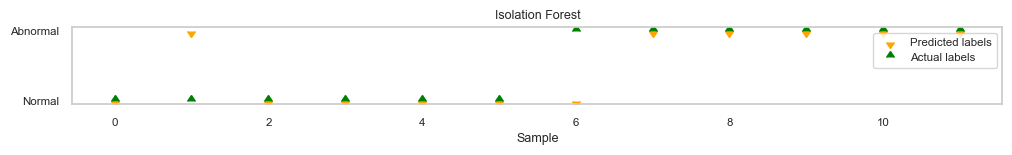

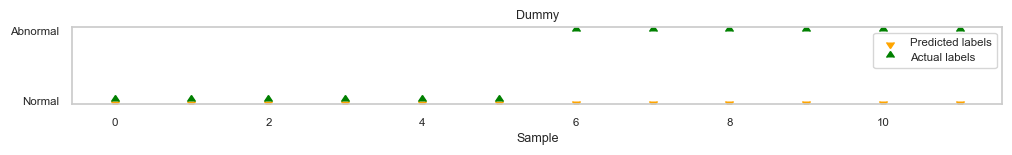

instance 23: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00012_20170320021000.csv
	skipped because normal_period_size is insufficient for training (0)
instance 24: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00012_20170320133144.csv
	skipped because normal_period_size is insufficient for training (0)
instance 25: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\2\WELL-00013_20170329020229.csv
	skipped because normal_period_size is insufficient for training (0)
instance 26: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00015_20170620040530.csv


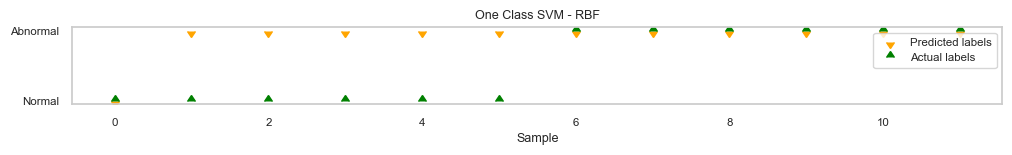

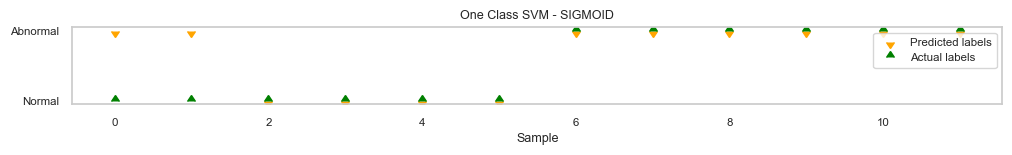

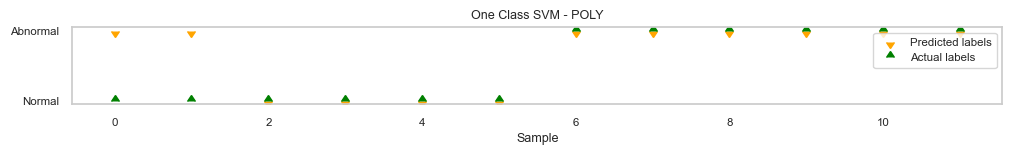

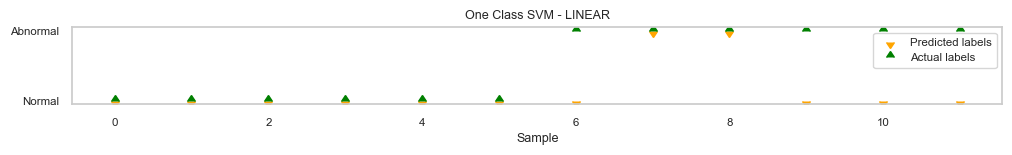

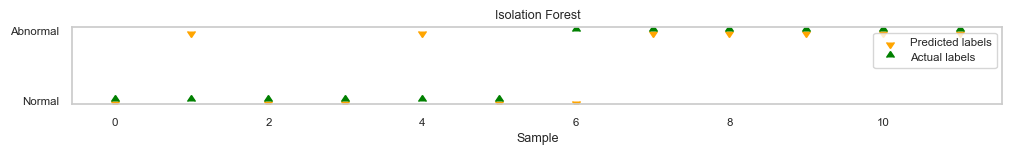

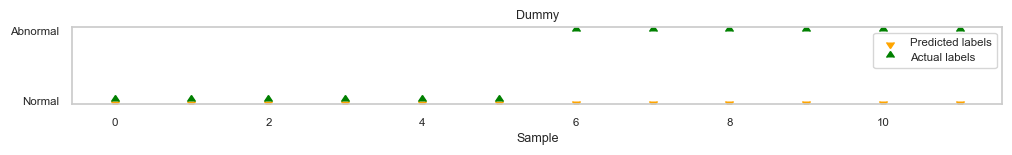

instance 27: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00016_20180404222255.csv


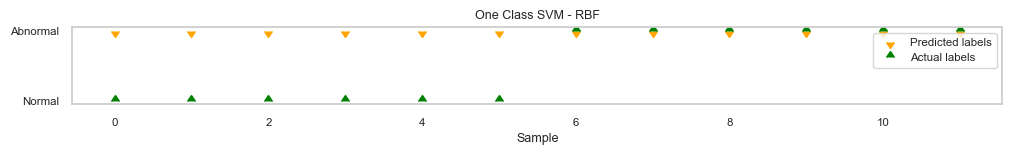

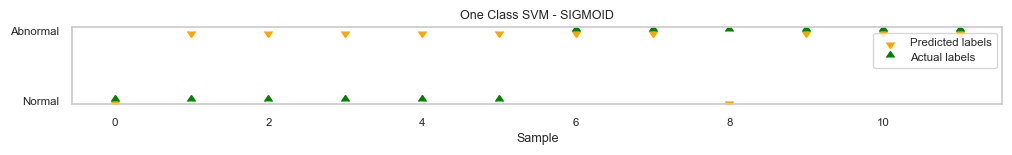

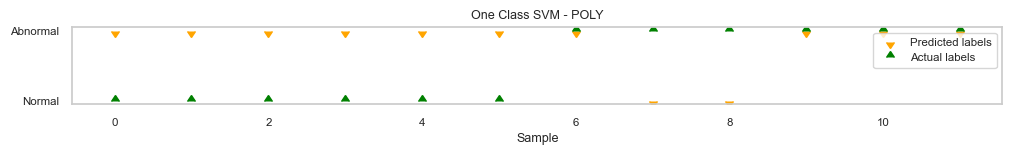

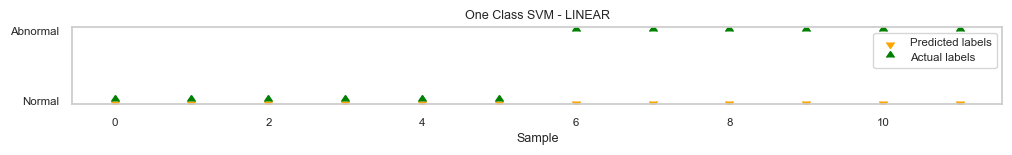

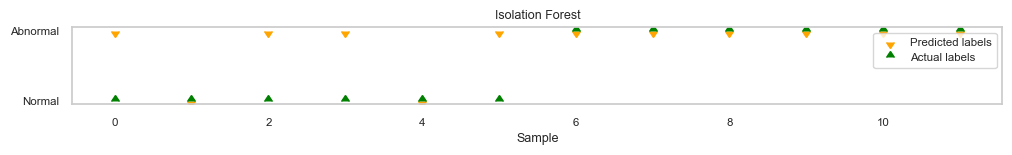

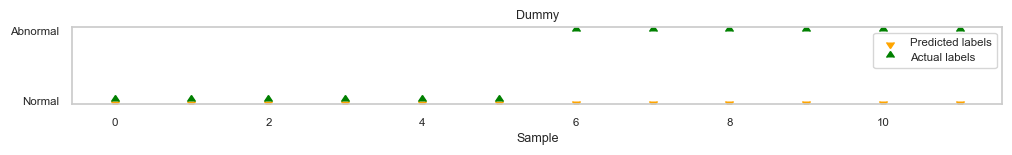

instance 28: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00016_20180426102531.csv
	skipped because normal_period_size is insufficient for training (502)
instance 29: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00016_20180426105723.csv
	skipped because normal_period_size is insufficient for training (376)
instance 30: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00016_20180517184536.csv


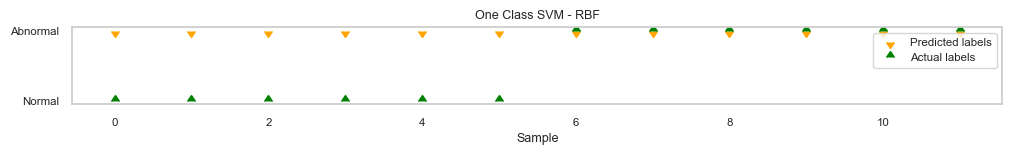

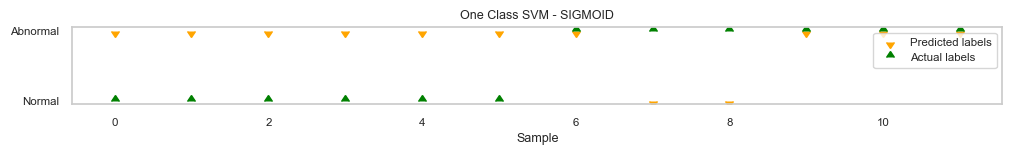

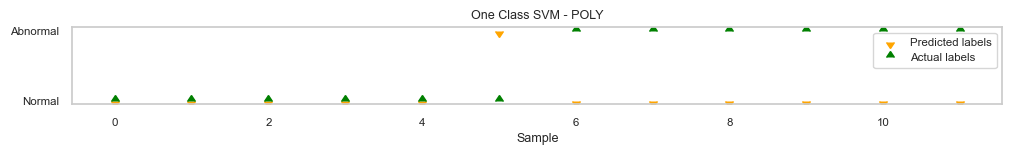

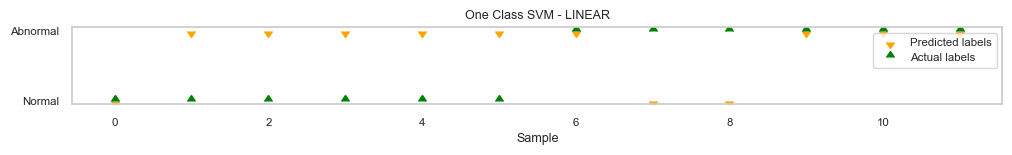

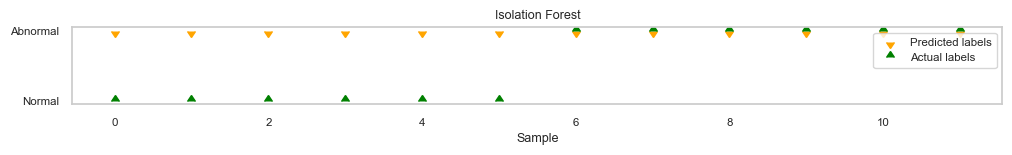

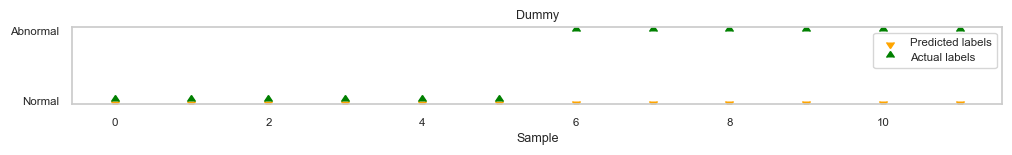

instance 31: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00017_20140314135248.csv


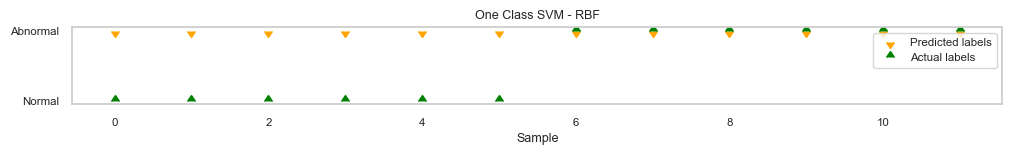

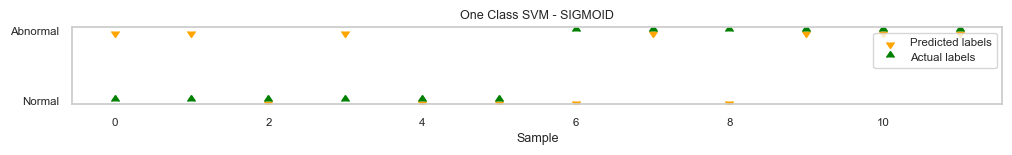

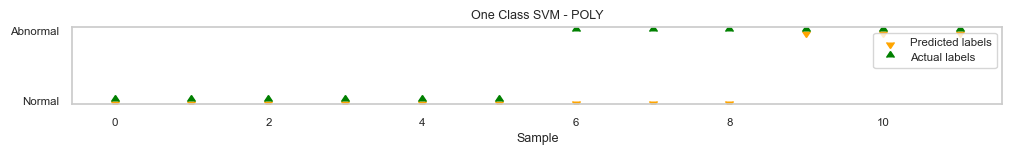

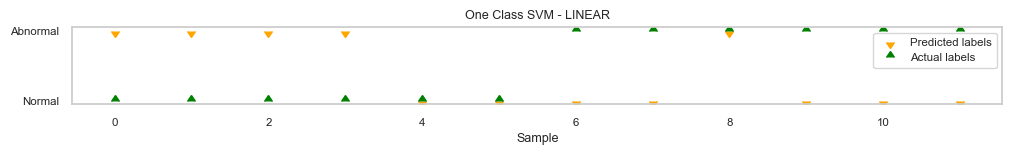

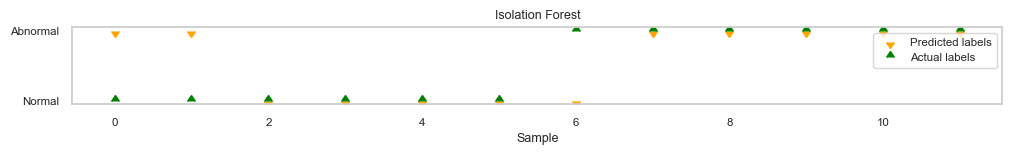

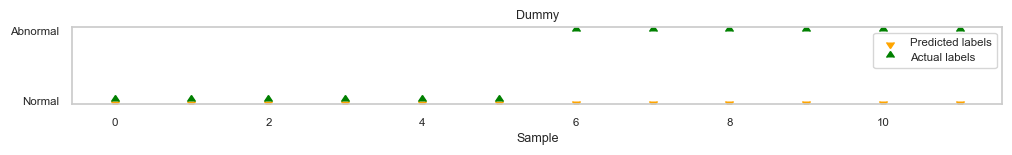

instance 32: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00017_20140317123419.csv


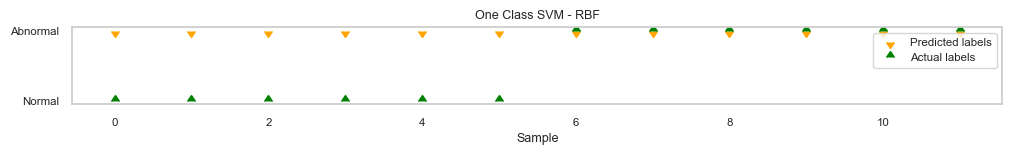

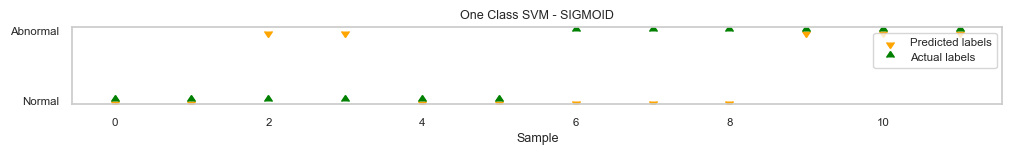

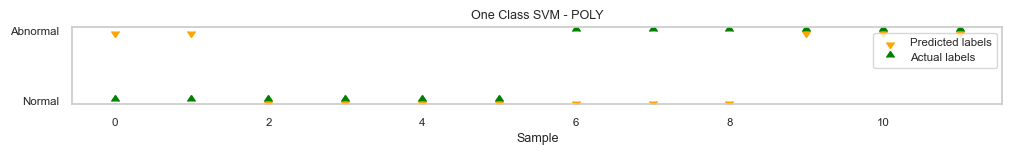

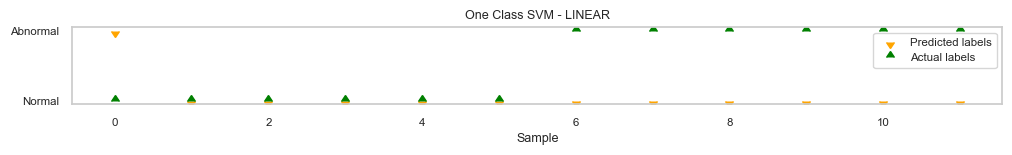

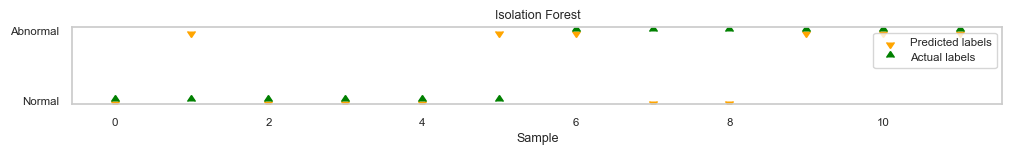

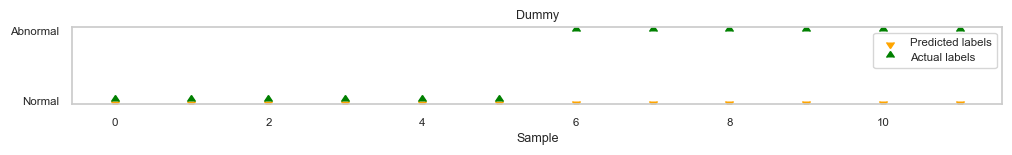

instance 33: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00017_20140317225927.csv


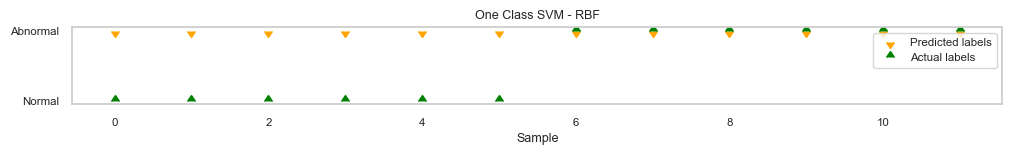

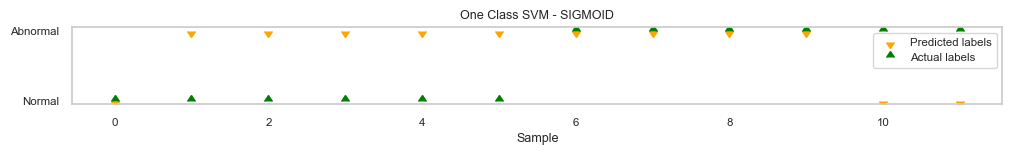

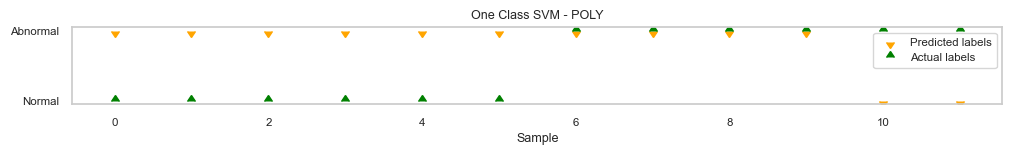

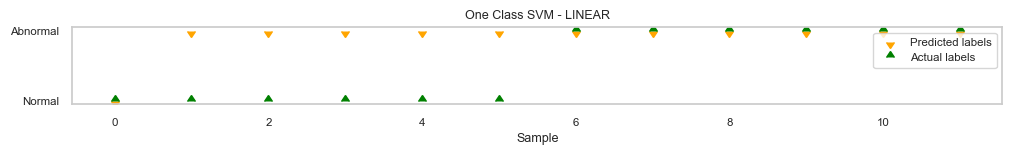

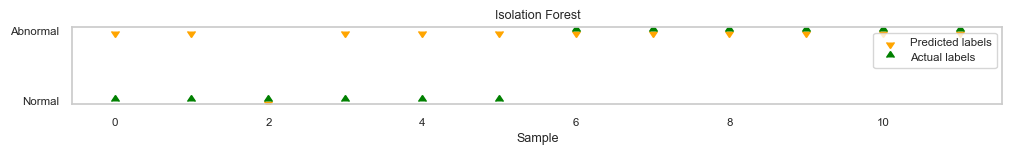

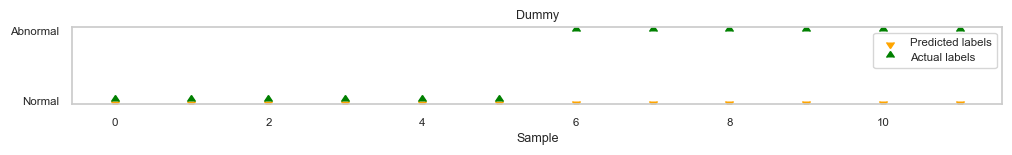

instance 34: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00017_20140318130603.csv


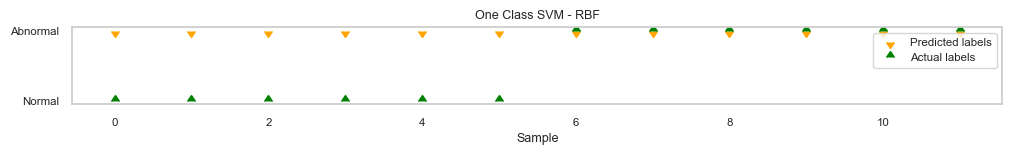

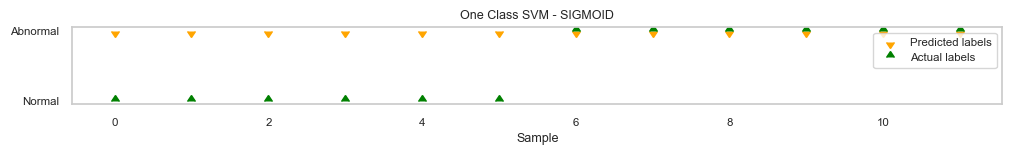

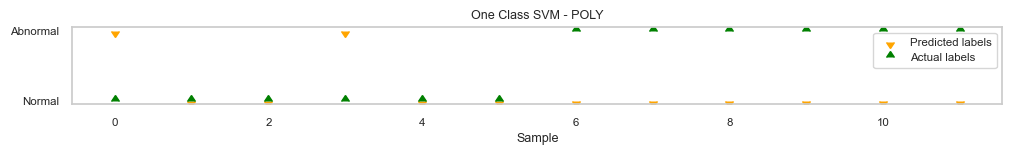

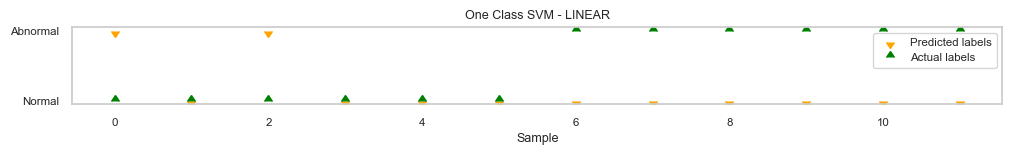

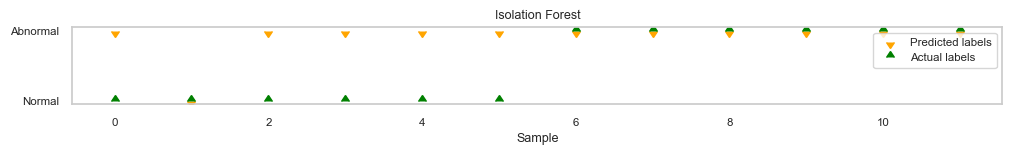

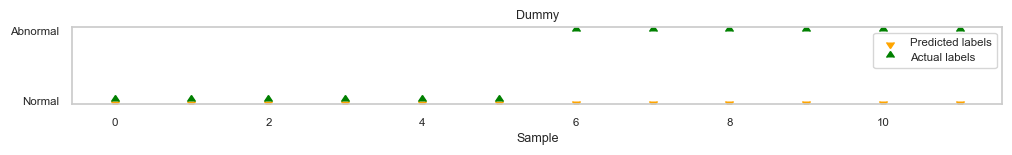

instance 35: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00017_20140319020130.csv


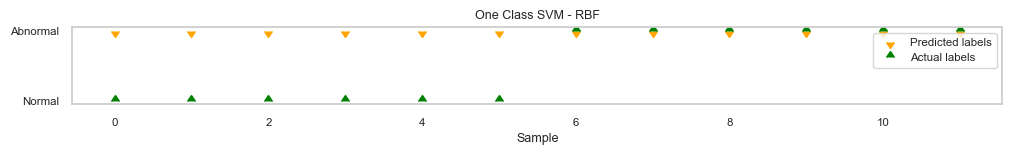

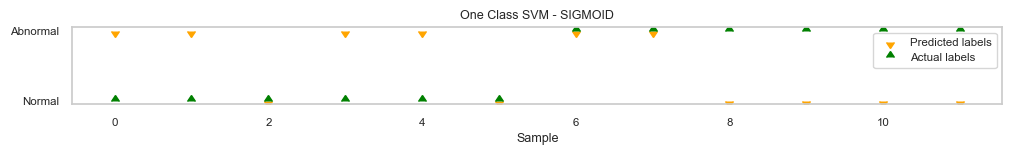

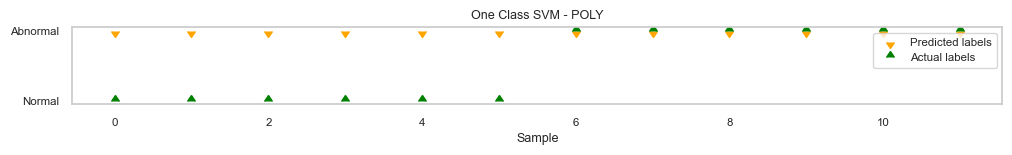

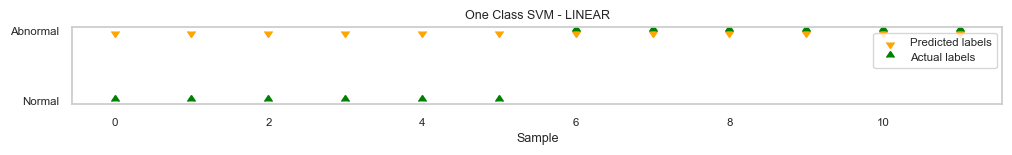

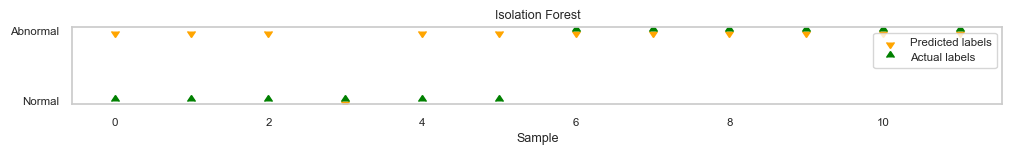

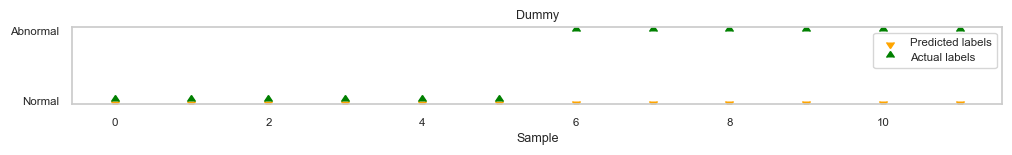

instance 36: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\5\WELL-00017_20140319031616.csv


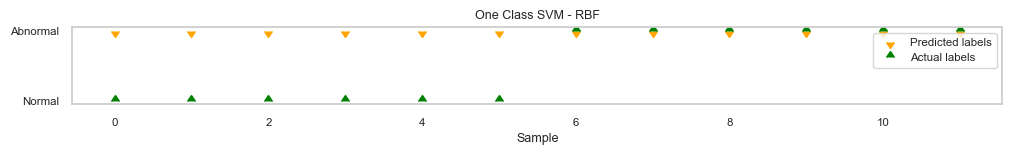

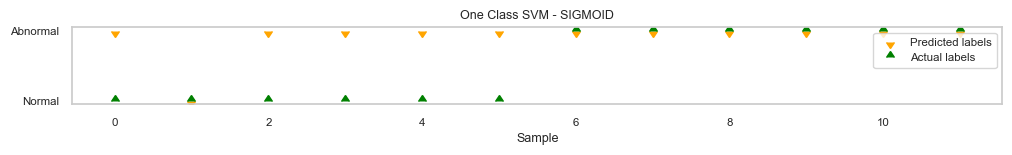

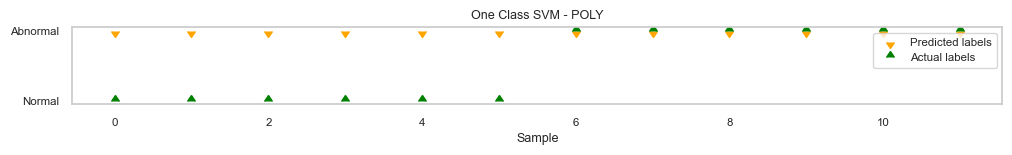

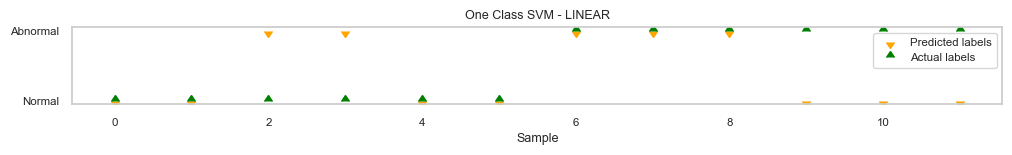

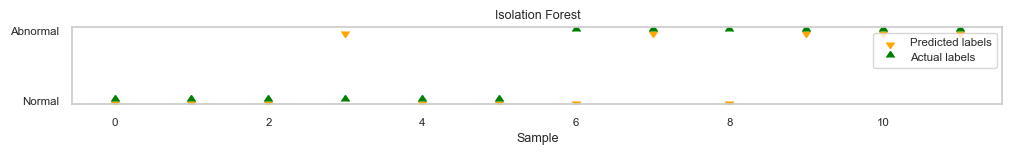

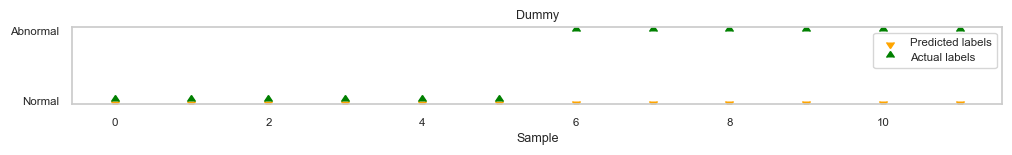

instance 37: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\6\WELL-00002_20140212170333.csv


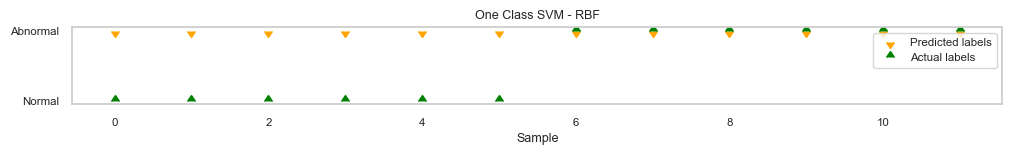

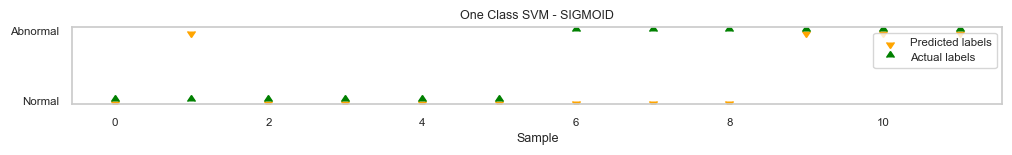

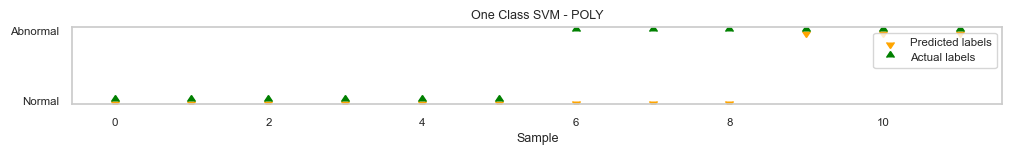

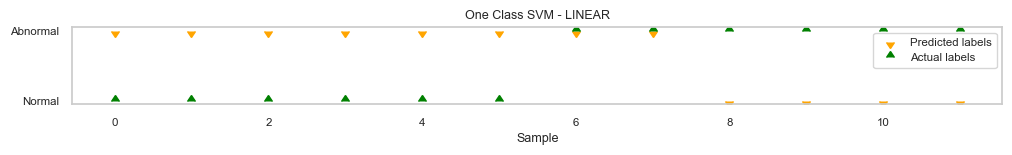

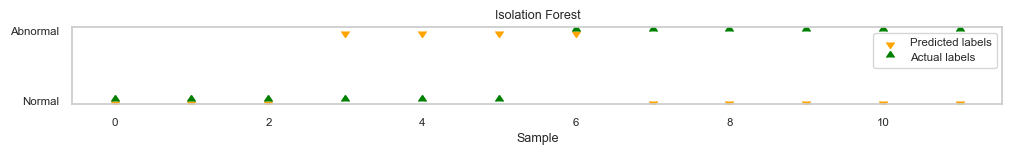

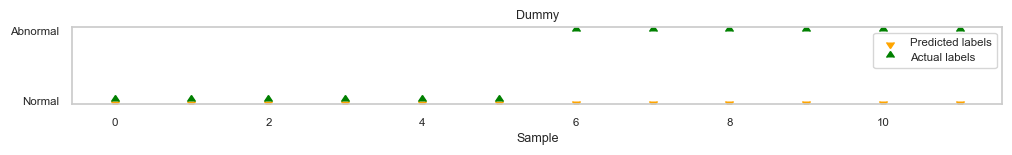

instance 38: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\6\WELL-00002_20140301151700.csv


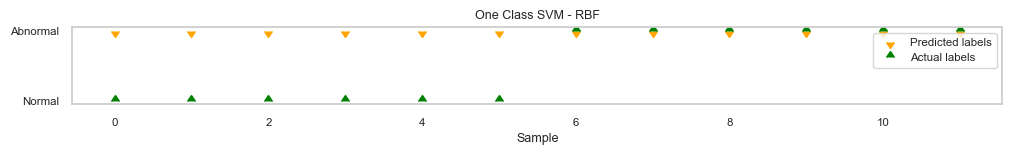

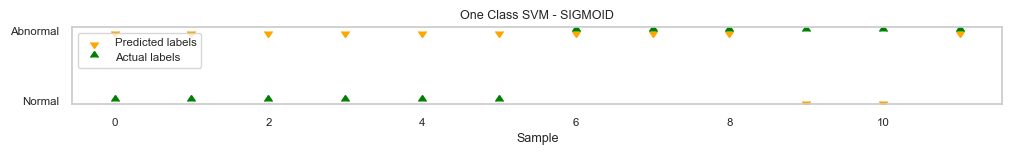

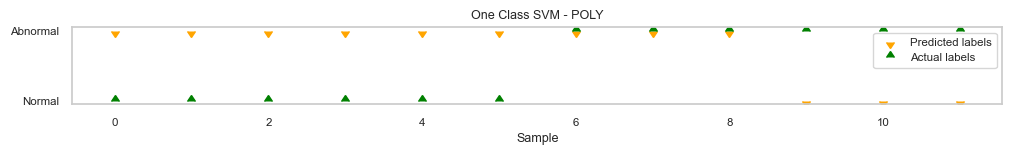

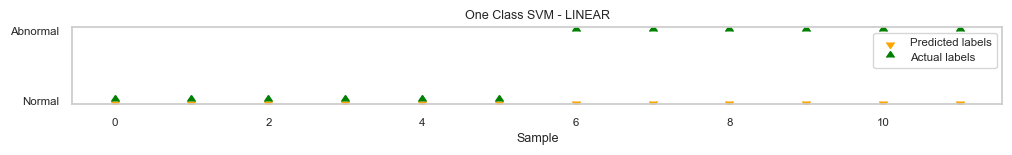

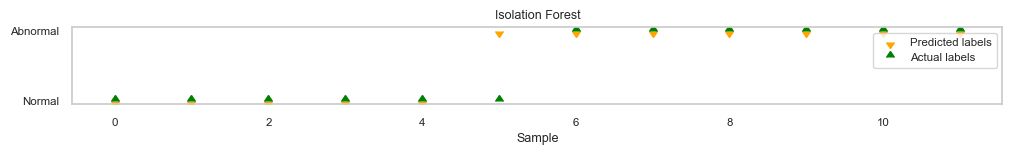

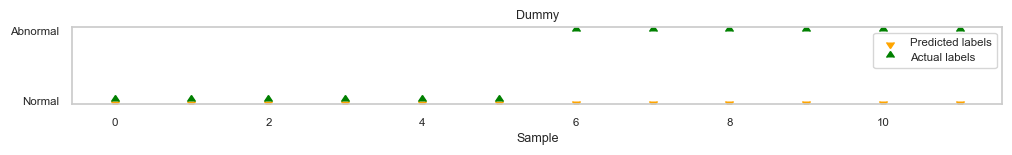

instance 39: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\6\WELL-00002_20140325170304.csv


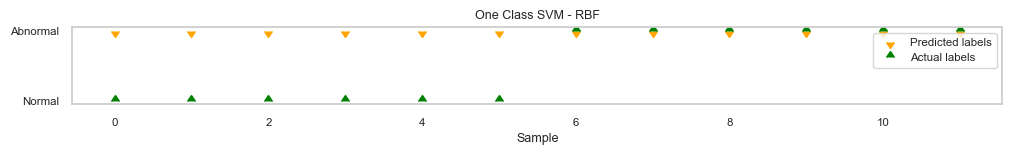

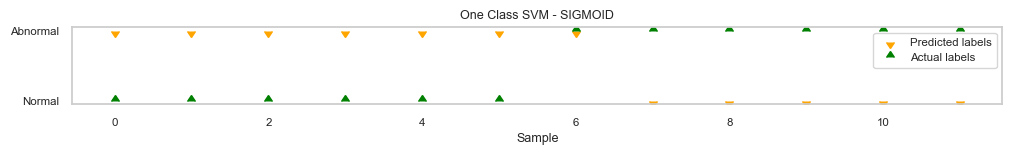

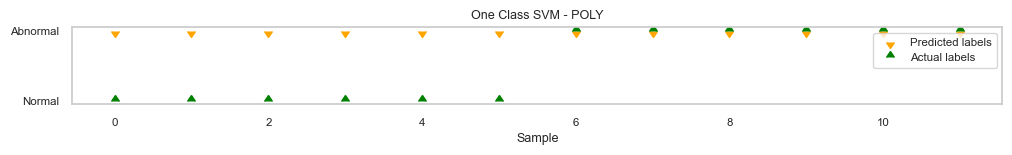

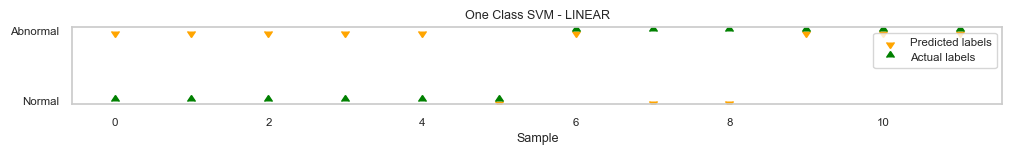

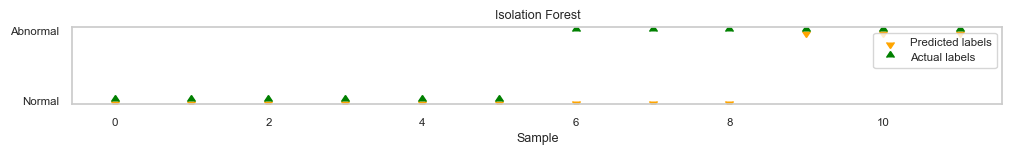

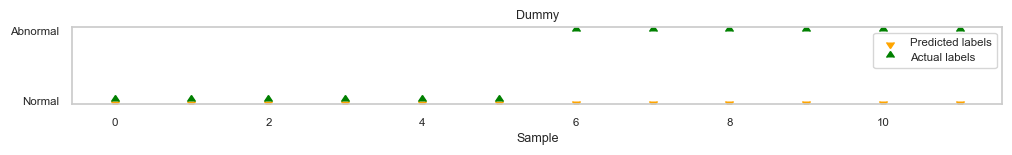

instance 40: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\6\WELL-00004_20171031181509.csv


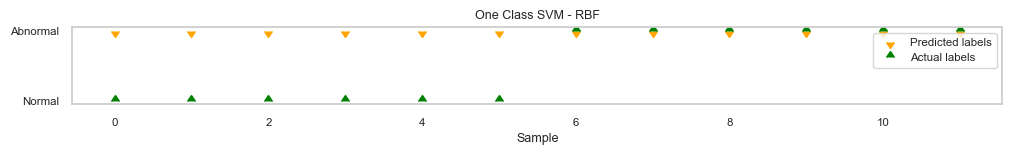

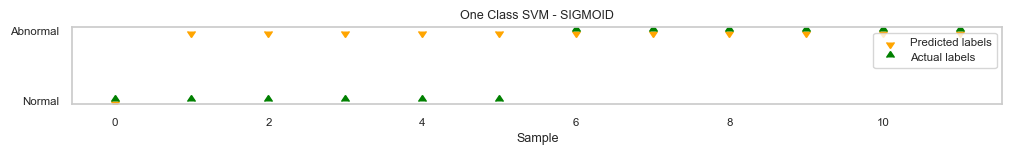

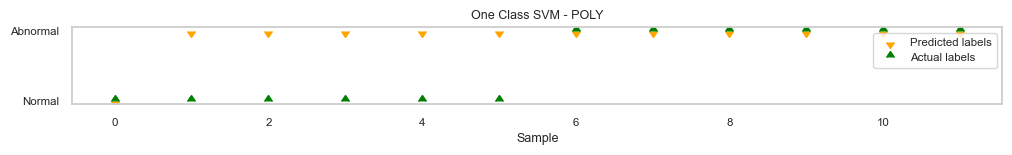

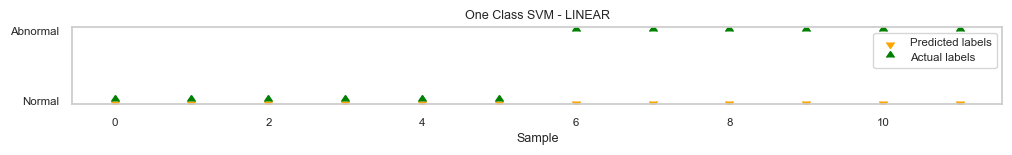

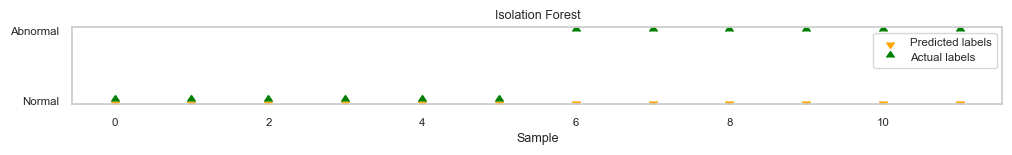

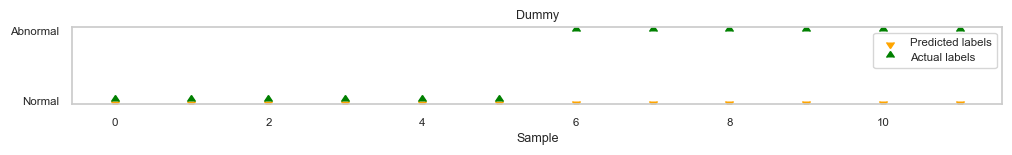

instance 41: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\6\WELL-00004_20171031190706.csv


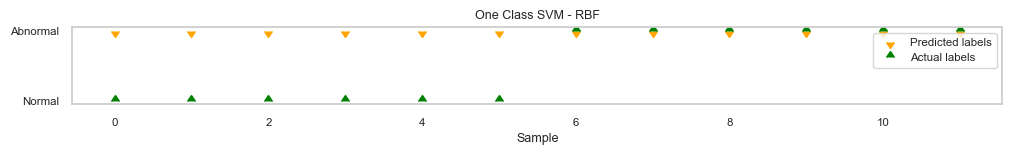

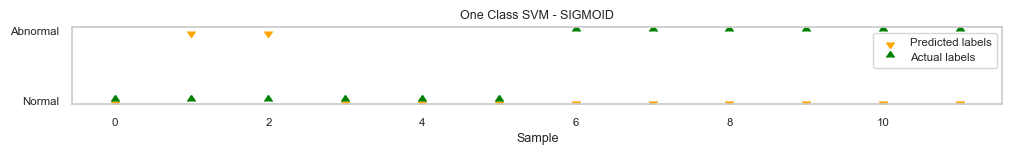

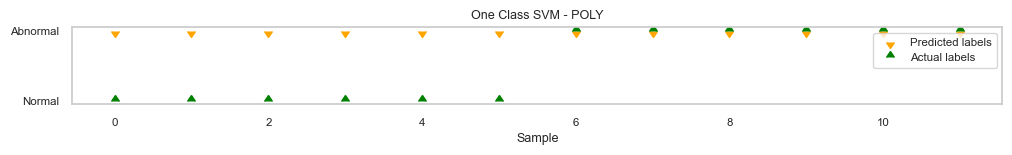

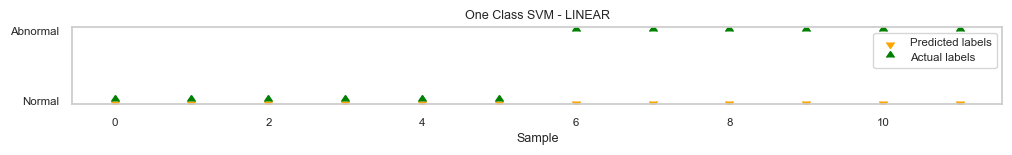

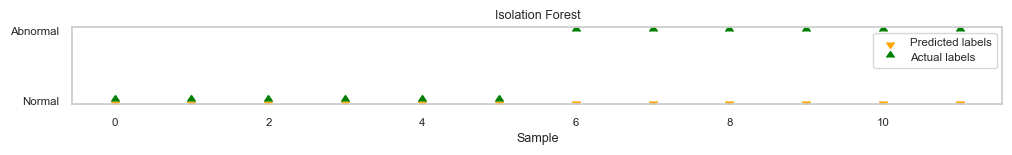

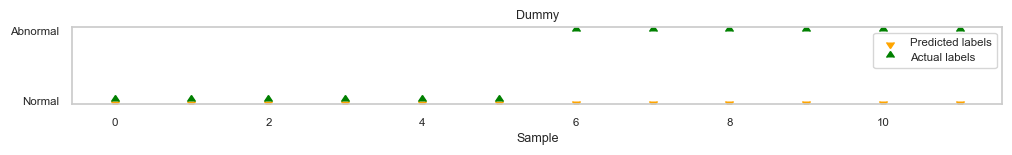

instance 42: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\6\WELL-00004_20171031194452.csv


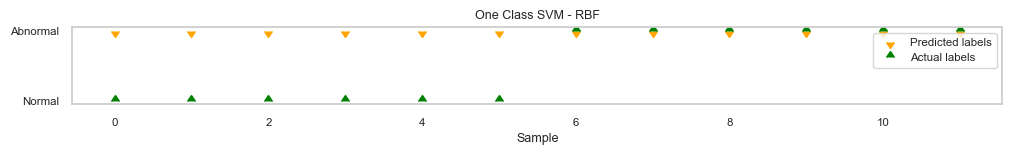

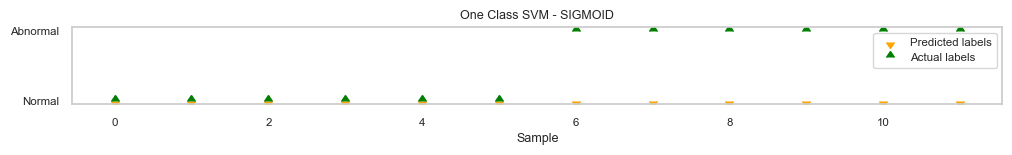

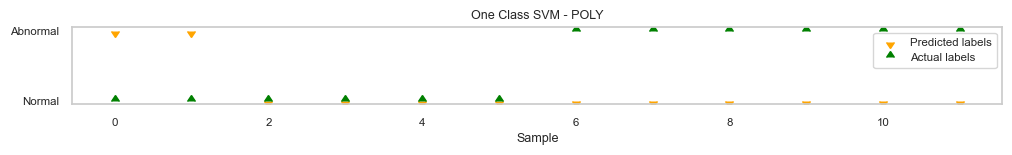

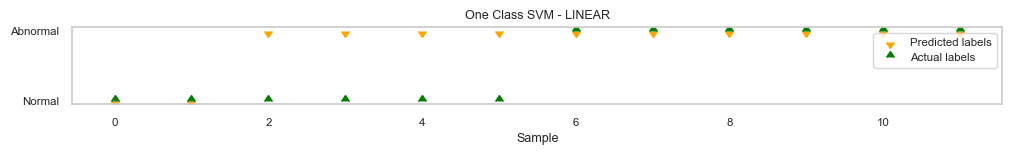

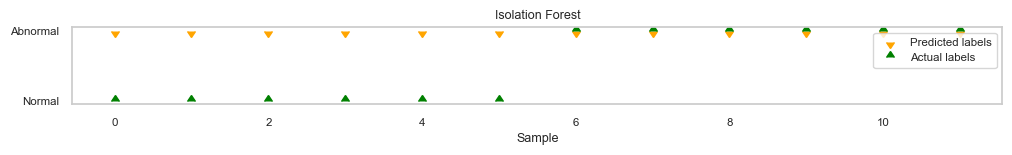

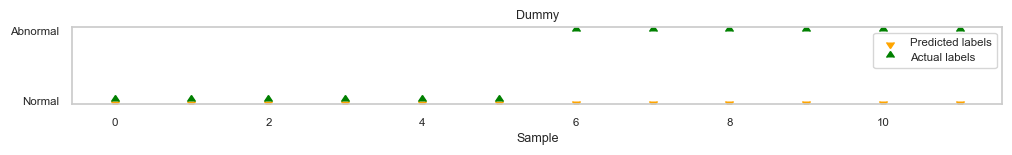

instance 43: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\7\WELL-00001_20170226140146.csv


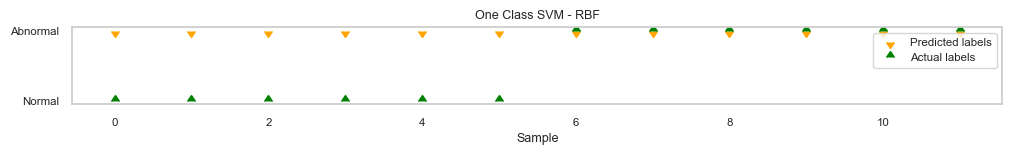

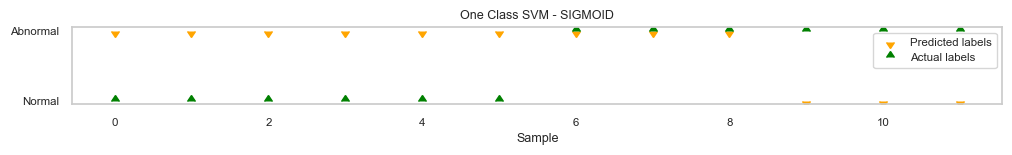

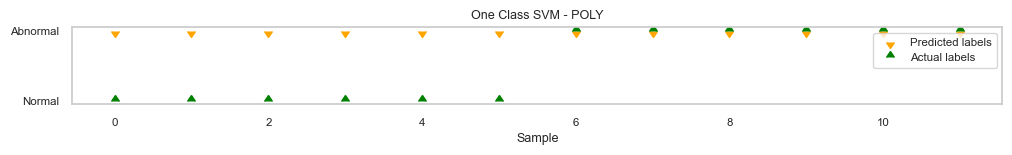

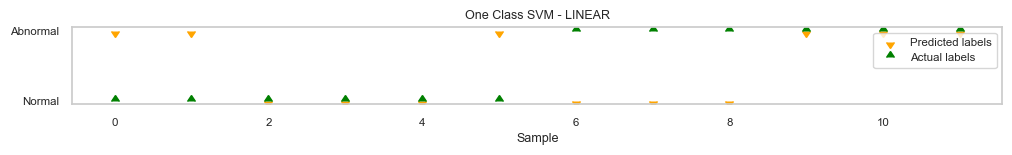

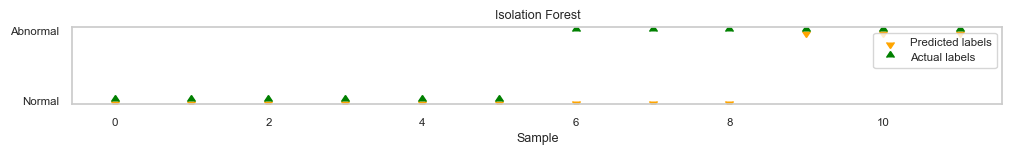

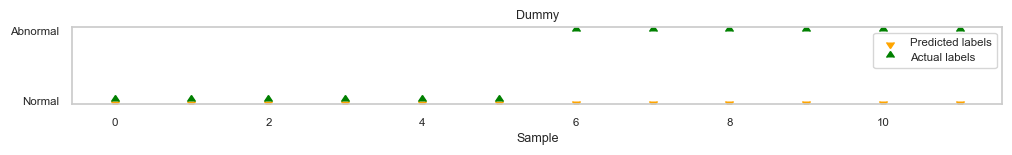

instance 44: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\7\WELL-00006_20180617181315.csv


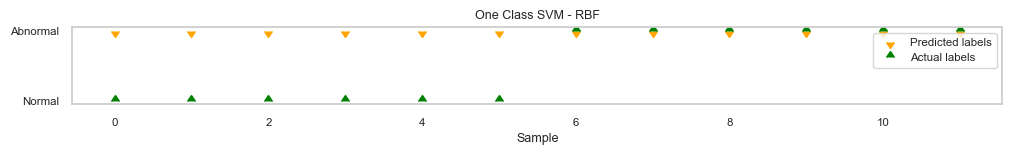

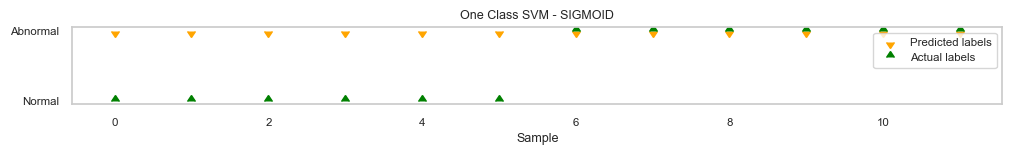

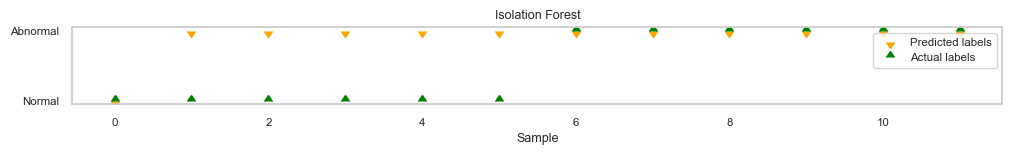

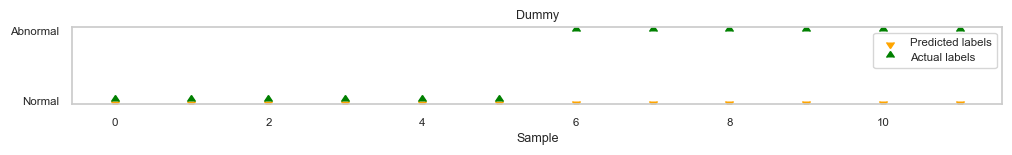

instance 45: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\7\WELL-00006_20180620155728.csv


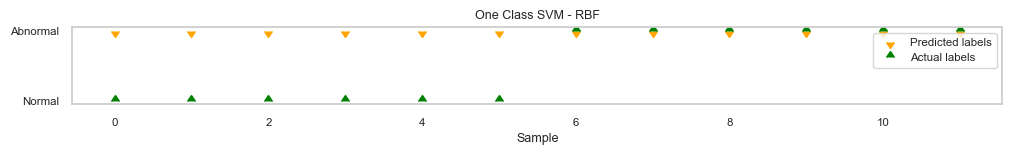

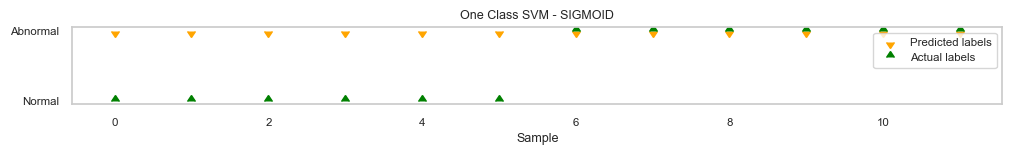

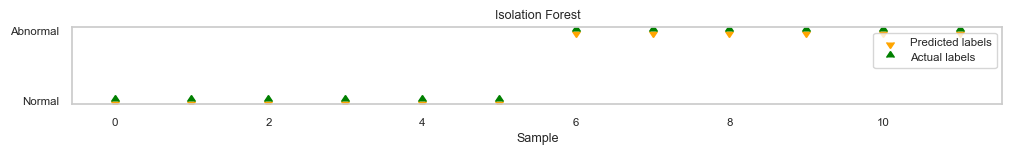

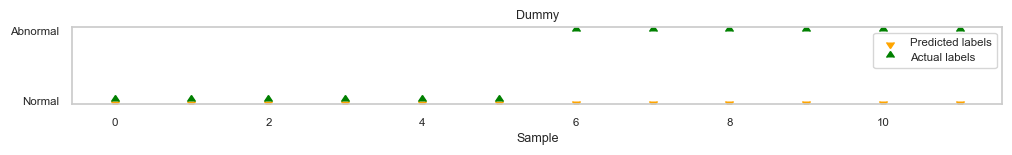

instance 46: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\7\WELL-00018_20180611021218.csv


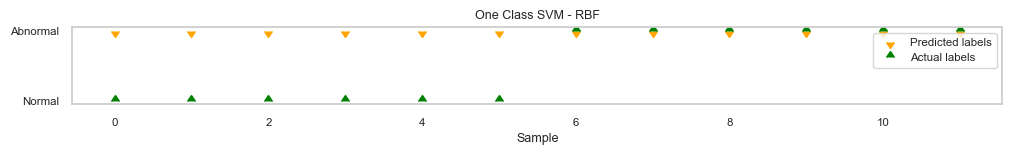

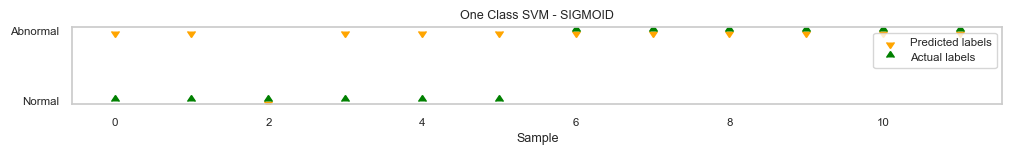

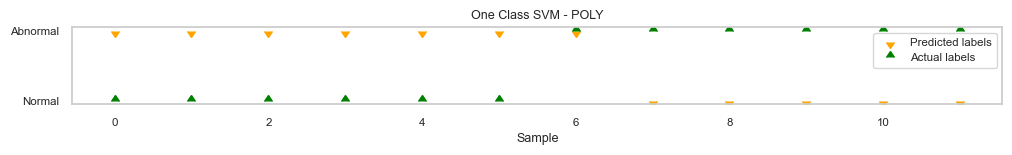

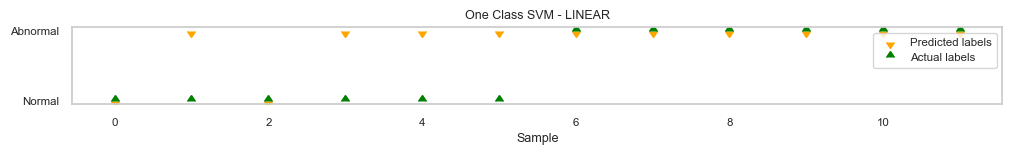

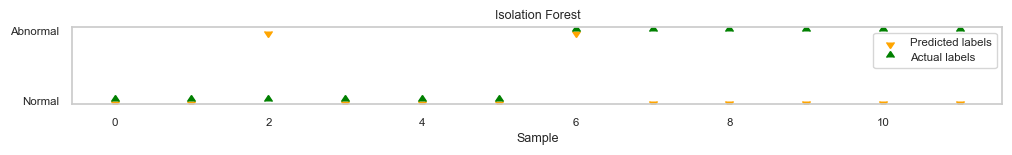

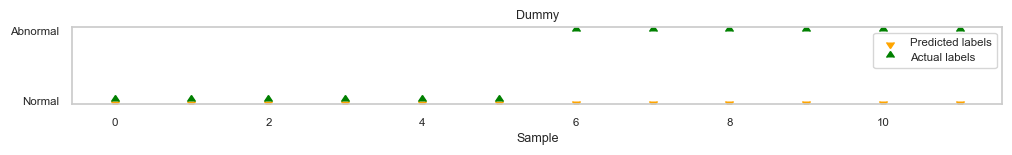

instance 47: C:\Users\ianry\Desktop\banco de dados\3W-main\3W-main\dataset\7\WELL-00018_20190403023307.csv


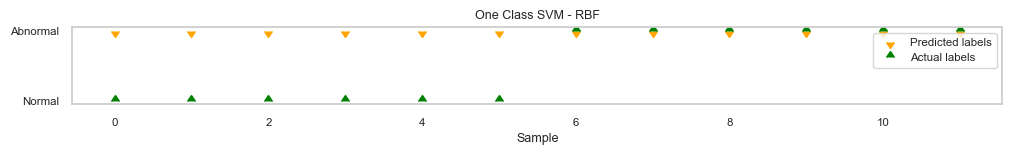

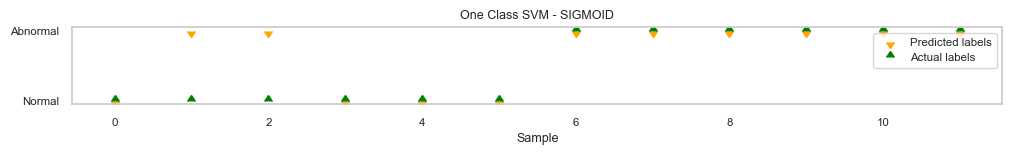

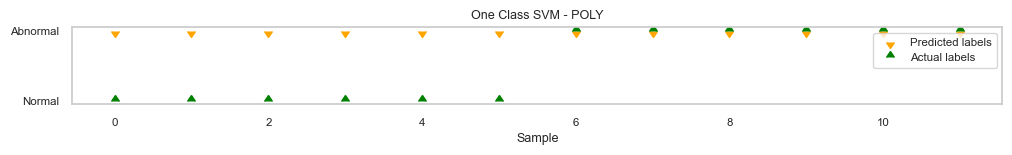

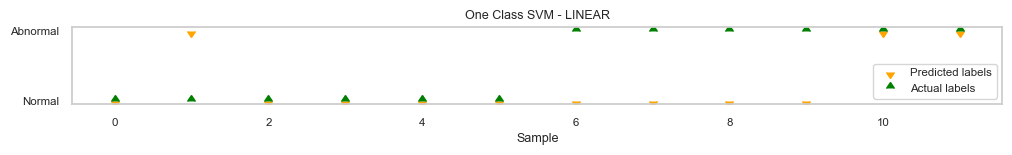

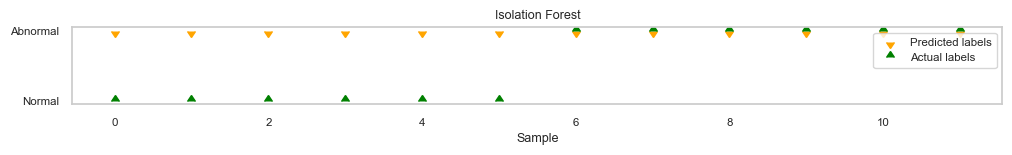

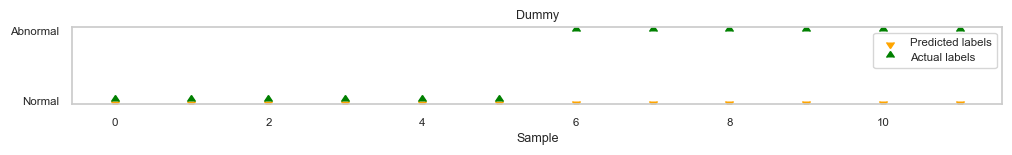

In [26]:
# For each real instance with any type of undesirable event
scores = pd.DataFrame()
ignored_instances = 0
used_instances = 0
for i, row in real_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    print('instance {}: {}'.format(i+1, instance_path))
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        print('\tskipped because normal_period_size is insufficient for training ({})'
              .format(normal_period_size))
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret

    # Changes types of the labels (tsfresh's requirement)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # We want binary classification: 1 for inliers (negative class = normal instance) and
    # -1 for outliers (positive class = instance with anomaly) (sklearn's requirement)
    y_test[y_test!=normal_class_code] = -1
    y_test[y_test==normal_class_code] = 1
    
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars]).astype('float32')
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars]).astype('float32')
    
    # Extracts features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_test = extract_features(df_samples_test, 
                              column_id='id', 
                              column_sort='timestamp',
                              default_fc_parameters=df_fc_p,
                              impute_function=impute,
                              n_jobs=0,
                              disable_progressbar=disable_progressbar)
    X_test = X_test.reset_index(drop=True)
    
    # Trains, tests and calculates the scores
    scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs)

# 3. Results

The results obtained with the implemented method are presented below.

In [11]:
print('number of used instances: {}'.format(used_instances))
print('number of ignored instances: {}'.format(ignored_instances))

number of used instances: 38
number of ignored instances: 9


In [12]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['median', 'mean', 'standard_deviation', 'variance', 'maximum', 'minimum']


The following commands conveniently permit saving and retrieving the results to/from a CSV file.

In [16]:
scores.to_csv(r'./Resultados_hiperparametro.csv')
#scores = pd.read_csv(r'./demo_2_benchmark_anomaly_detection_scores.csv', index_col=0)

# 3.1. Metrics in Tabular Format

The following tables present the averages and standard deviation of the metrics, respectively. Both are ordered by F1 metric.

In [27]:
score_table = scores.groupby('CLASSIFIER').mean().sort_values(by=['F1'], ascending=False)
score_table

,PRECISION,RECALL,F1,TRAINING[s],TESTING[s]
CLASSIFIER,,,,,
Isolation Forest,0.682018,0.682018,0.682018,0.250230,0.051341
One Class SVM - RBF,0.546053,0.546053,0.546053,0.001448,0.001151
One Class SVM - LINEAR,0.533333,0.533333,0.533333,0.001469,0.001228
One Class SVM - SIGMOID,0.515351,0.515351,0.515351,0.001758,0.001373
Dummy,0.500000,0.500000,0.500000,0.000288,0.000057
One Class SVM - POLY,0.385714,0.385714,0.385714,0.001641,0.001162
Local Outlier Factor,NaN,NaN,NaN,NaN,NaN


In [28]:
scores.groupby('CLASSIFIER').std().sort_values(by=['F1'], ascending=True)

,PRECISION,RECALL,F1,TRAINING[s],TESTING[s]
CLASSIFIER,,,,,
Dummy,0.000000,0.000000,0.000000,0.000466,0.000245
One Class SVM - RBF,0.115758,0.115758,0.115758,0.000694,0.000669
Isolation Forest,0.176357,0.176357,0.176357,0.021794,0.005555
One Class SVM - LINEAR,0.178730,0.178730,0.178730,0.000660,0.000629
One Class SVM - SIGMOID,0.215621,0.215621,0.215621,0.000709,0.000509
One Class SVM - POLY,0.216823,0.216823,0.216823,0.000595,0.000668
Local Outlier Factor,NaN,NaN,NaN,NaN,NaN


# 3.2. Metrics in Boxplots

The boxplots presented below are ordered by F1 mean values of the considered classifiers.

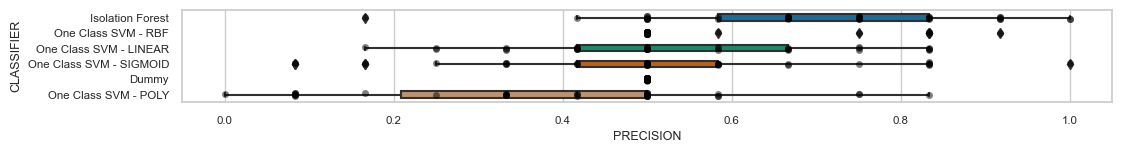

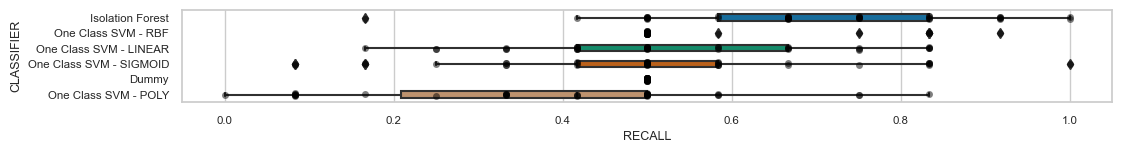

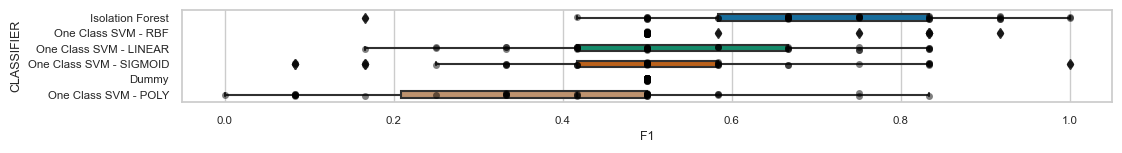

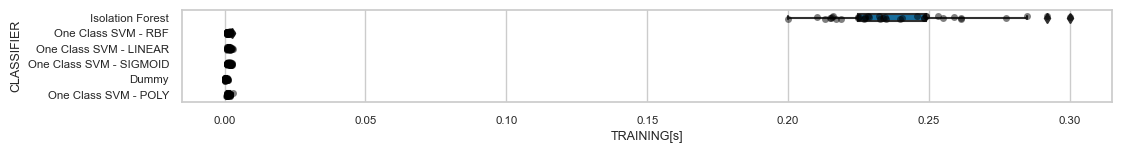

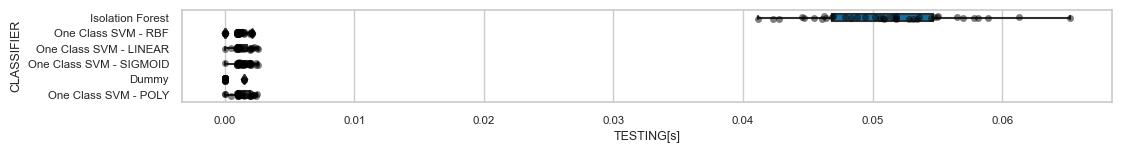

In [15]:
sns.set(font_scale=0.75, style="whitegrid")
for score in scores.columns.drop(['CLASSIFIER']):
    plt.figure(figsize=(12,1.2))
    bplot=sns.boxplot(y='CLASSIFIER', x=score, data=scores, width=0.4, 
                      palette='colorblind', order=list(score_table.index));
    bplot=sns.stripplot(y='CLASSIFIER', x=score, data=scores, jitter=True, marker='o', 
                        alpha=0.5, color='black', order=list(score_table.index))